In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
#from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('parkinson_disease.csv')
df.shape

(756, 755)

In [3]:
xx = df['class'].value_counts()

xx

class
1    564
0    192
Name: count, dtype: int64

In [4]:
print(', '.join(df.columns))

id, gender, PPE, DFA, RPDE, numPulses, numPeriodsPulses, meanPeriodPulses, stdDevPeriodPulses, locPctJitter, locAbsJitter, rapJitter, ppq5Jitter, ddpJitter, locShimmer, locDbShimmer, apq3Shimmer, apq5Shimmer, apq11Shimmer, ddaShimmer, meanAutoCorrHarmonicity, meanNoiseToHarmHarmonicity, meanHarmToNoiseHarmonicity, minIntensity, maxIntensity, meanIntensity, f1, f2, f3, f4, b1, b2, b3, b4, GQ_prc5_95, GQ_std_cycle_open, GQ_std_cycle_closed, GNE_mean, GNE_std, GNE_SNR_TKEO, GNE_SNR_SEO, GNE_NSR_TKEO, GNE_NSR_SEO, VFER_mean, VFER_std, VFER_entropy, VFER_SNR_TKEO, VFER_SNR_SEO, VFER_NSR_TKEO, VFER_NSR_SEO, IMF_SNR_SEO, IMF_SNR_TKEO, IMF_SNR_entropy, IMF_NSR_SEO, IMF_NSR_TKEO, IMF_NSR_entropy, mean_Log_energy, mean_MFCC_0th_coef, mean_MFCC_1st_coef, mean_MFCC_2nd_coef, mean_MFCC_3rd_coef, mean_MFCC_4th_coef, mean_MFCC_5th_coef, mean_MFCC_6th_coef, mean_MFCC_7th_coef, mean_MFCC_8th_coef, mean_MFCC_9th_coef, mean_MFCC_10th_coef, mean_MFCC_11th_coef, mean_MFCC_12th_coef, mean_delta_log_energy, 

# Explore Features

In [5]:
import pandas as pd
from collections import defaultdict

# -----------------------------
# STEP 1: Load dataset
# -----------------------------
df = pd.read_csv("parkinson_disease.csv")
all_features = df.columns.tolist()

# -----------------------------
# STEP 2: Define main groups
# -----------------------------
group_keywords = {
    "Demographics": ["id", "gender"],
    "Traditional Voice Measures": ["PPE", "DFA", "RPDE", "Jitter", "Shimmer", "Intensity"],
    "Glottal & Harmonicity Features": ["Harmonicity", "GQ_", "meanAutoCorr", "meanNoiseToHarm", "meanHarmToNoise"],
    "Formants & Bandwidths": ["f1", "f2", "f3", "f4", "b1", "b2", "b3", "b4"],
    "MFCC & Log Energy Features": ["MFCC", "log_energy", "delta", "delta_delta"],
    "GNE Features": ["GNE_"],
    "VFER / IMF Features": ["VFER_", "IMF_"],
    "Wavelet Energy & Entropy": ["tqwt_energy", "tqwt_entropy", "tqwt_TKEO", "tqwt_meanValue", "tqwt_medianValue", "tqwt_stdValue", "tqwt_minValue", "tqwt_maxValue", "tqwt_skewnessValue", "tqwt_kurtosisValue"],
    "Deterministic / Approximate Entropy": ["det_", "app_", "Ed_", "Ed2_"],
    "Higher-Order Energy Features": ["Ea", "Ea2"],
    "Misc / Other": []  # fallback
}

# Assign main group to each feature
def assign_group(feature_name):
    for group, keywords in group_keywords.items():
        for kw in keywords:
            if kw in feature_name:
                return group
    return "Misc / Other"

grouped_df = pd.DataFrame([
    {"feature": feat, "group": assign_group(feat)}
    for feat in all_features
])

In [6]:
print("\n Main Feature Group Summary:")
print(grouped_df["group"].value_counts())


 Main Feature Group Summary:
group
Wavelet Energy & Entropy               432
Deterministic / Approximate Entropy    180
MFCC & Log Energy Features              82
Traditional Voice Measures              17
VFER / IMF Features                     13
Formants & Bandwidths                    8
Misc / Other                             7
Glottal & Harmonicity Features           6
GNE Features                             6
Demographics                             2
Higher-Order Energy Features             2
Name: count, dtype: int64


In [7]:
# -----------------------------
# STEP 3: Define TQWT subgroups
# -----------------------------
tqwt_subgroups = {
    "TQWT_Energy": "tqwt_energy_dec_",
    "TQWT_Entropy_Shannon": "tqwt_entropy_shannon_dec_",
    "TQWT_Entropy_Log": "tqwt_entropy_log_dec_",
    "TQWT_TKEO_Mean": "tqwt_TKEO_mean_dec_",
    "TQWT_TKEO_Std": "tqwt_TKEO_std_dec_",
    "TQWT_Stat_Mean": "tqwt_meanValue_dec_",
    "TQWT_Stat_Median": "tqwt_medianValue_dec_",
    "TQWT_Stat_Std": "tqwt_stdValue_dec_",
    "TQWT_Stat_Min": "tqwt_minValue_dec_",
    "TQWT_Stat_Max": "tqwt_maxValue_dec_",
    "TQWT_Stat_Skewness": "tqwt_skewnessValue_dec_",
    "TQWT_Stat_Kurtosis": "tqwt_kurtosisValue_dec_"
}

# -----------------------------
# STEP 4: Define Det/App subgroups (including LT variants)
# -----------------------------
det_app_subgroups = {
    # Approximate (normal + LT)
    "App_TKEO_Mean": ["app_TKEO_mean_", "app_det_TKEO_mean_", "app_LT_TKEO_mean_"],
    "App_TKEO_Std": ["app_TKEO_std_", "app_LT_TKEO_std_"],
    "App_Entropy_Shannon": ["app_entropy_shannon_", "app_LT_entropy_shannon_"],
    "App_Entropy_Log": ["app_entropy_log_", "app_LT_entropy_log_"],

    # Deterministic (normal + LT)
    "Det_TKEO_Mean": ["det_TKEO_mean_", "det_LT_TKEO_mean_"],
    "Det_TKEO_Std": ["det_TKEO_std_", "det_LT_TKEO_std_"],
    "Det_Entropy_Shannon": ["det_entropy_shannon_", "det_LT_entropy_shannon_"],
    "Det_Entropy_Log": ["det_entropy_log_", "det_LT_entropy_log_"],

    # Energy
    "Ed_Coef": ["Ed_"],
    "Ed2_Coef": ["Ed2_"]
}

import re

mfcc_subgroups = {
    "MFCC_Mean": lambda f: f.startswith("mean_MFCC_"),
    "MFCC_Std": lambda f: f.startswith("std_MFCC_"),
    
    "Log_Energy_Mean": lambda f: f in ["mean_Log_energy", "mean_delta_log_energy"],
    "Log_Energy_Std": lambda f: f in ["std_Log_energy", "std_delta_log_energy"],

    "MFCC_Delta_Mean": lambda f: re.match(r"^mean_.*_delta$", f) is not None,
    "MFCC_Delta_Std": lambda f: re.match(r"^std_.*_delta$", f) is not None,

    "MFCC_DeltaDelta_Mean": lambda f: re.match(r"^mean_.*_delta_delta", f) is not None,
    "MFCC_DeltaDelta_Std": lambda f: re.match(r"^std_.*_delta_delta", f) is not None
}

# Normalize all values to lists in case any are strings
for key in det_app_subgroups:
    if isinstance(det_app_subgroups[key], str):
        det_app_subgroups[key] = [det_app_subgroups[key]]


In [8]:
# -----------------------------
# STEP 5: Assign subgroups
# -----------------------------
def assign_subgroup(row):
    feat = row["feature"]
    group = row["group"]

    if group == "Wavelet Energy & Entropy":
        for name, key in tqwt_subgroups.items():
            if key in feat:
                return name

    elif group == "Deterministic / Approximate Entropy":
        # Prioritize app_ keys before det_ to avoid misclassification
        ordered_subgroups = list(det_app_subgroups.items())
        ordered_subgroups.sort(key=lambda x: 0 if any("app_" in k for k in x[1]) else 1)
        
        for name, patterns in ordered_subgroups:
            for pattern in patterns:
                if pattern in feat:
                    return name
                
    elif group == "MFCC & Log Energy Features":
        for name, check_fn in mfcc_subgroups.items():
            if check_fn(feat):
                return name

grouped_df["subgroup"] = grouped_df.apply(assign_subgroup, axis=1)


In [9]:
# Det/App subgroup summary
print("\n Det/App Entropy Subgroup Summary:")
print(grouped_df[grouped_df["group"] == "Deterministic / Approximate Entropy"]["subgroup"].value_counts())


 Det/App Entropy Subgroup Summary:
subgroup
Det_Entropy_Shannon    20
Det_Entropy_Log        20
Det_TKEO_Mean          20
Det_TKEO_Std           20
App_Entropy_Shannon    20
App_Entropy_Log        20
App_TKEO_Mean          20
App_TKEO_Std           20
Ed_Coef                10
Ed2_Coef               10
Name: count, dtype: int64


In [10]:
# TQWT subgroup summary
print("\n TQWT Subgroup Summary:")
print(grouped_df[grouped_df["group"] == "Wavelet Energy & Entropy"]["subgroup"].value_counts())


 TQWT Subgroup Summary:
subgroup
TQWT_Energy             36
TQWT_Entropy_Shannon    36
TQWT_Entropy_Log        36
TQWT_TKEO_Mean          36
TQWT_TKEO_Std           36
TQWT_Stat_Median        36
TQWT_Stat_Mean          36
TQWT_Stat_Std           36
TQWT_Stat_Min           36
TQWT_Stat_Max           36
TQWT_Stat_Skewness      36
TQWT_Stat_Kurtosis      36
Name: count, dtype: int64


In [11]:
grouped_df["subgroup"] = grouped_df.apply(assign_subgroup, axis=1)

print("\n MFCC & Log Energy Subgroup Summary:")
print(grouped_df[grouped_df["group"] == "MFCC & Log Energy Features"]["subgroup"].value_counts())


 MFCC & Log Energy Subgroup Summary:
subgroup
MFCC_Delta_Mean    25
MFCC_Delta_Std     25
MFCC_Mean          13
MFCC_Std           13
Log_Energy_Mean     1
Log_Energy_Std      1
Name: count, dtype: int64


# Features reductions 

In [12]:
# Step 6: Apply median aggregation per subgroup
df_reduced = df.copy()

# Ensure 'class' is always retained
protected_features = ["class"]

# Get all unique subgroups (excluding NaN)
subgroup_names = grouped_df["subgroup"].dropna().unique()

for subgroup in subgroup_names:
    # Features in this subgroup
    features = grouped_df[grouped_df["subgroup"] == subgroup]["feature"].tolist()
    
    # Exclude protected features (e.g., 'class')
    features_to_use = [f for f in features if f not in protected_features]

    # Skip subgroup if empty after exclusion
    if not features_to_use:
        continue

    # Create median feature
    df_reduced[f"{subgroup}_median"] = df[features_to_use].median(axis=1)

    # Drop the original subgroup features (excluding protected ones)
    df_reduced.drop(columns=features_to_use, inplace=True)

# Save the reduced dataset to CSV
#df_reduced.to_csv("parkinson_disease_reduced.csv", index=False)

# Print summary
print(f"Reduced dataset saved with shape: {df_reduced.shape}")
print(f"File: parkinson_disease_reduced.csv")


Reduced dataset saved with shape: (756, 93)
File: parkinson_disease_reduced.csv


# Feature selection on reduced features data

In [13]:
# Step 1: Separate Features and Target
X = df_reduced.drop(columns=["class"])
y = df_reduced["class"]

In [14]:
# Step 2: Standardize Features 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Option A: Model-Based Feature Importance (Random Forest)

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)

importances = rf.feature_importances_
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)
print(feature_importance)

                       feature  importance
60  std_delta_delta_log_energy    0.061492
68       Log_Energy_Std_median    0.042313
10                locAbsJitter    0.023826
59              std_Log_energy    0.023353
35           GQ_std_cycle_open    0.021728
..                         ...         ...
70              Ed_Coef_median    0.004465
2                          PPE    0.004329
36         GQ_std_cycle_closed    0.004099
63                         Ea2    0.002362
1                       gender    0.000855

[92 rows x 2 columns]


# Option B: Univariate Feature Selection (e.g., ANOVA F-test)

In [16]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k='all')  # Try 'all' or an integer like 10
X_new = selector.fit_transform(X_scaled, y)

# View feature scores
import pandas as pd
feature_scores = pd.DataFrame({
    "feature": X.columns,
    "score": selector.scores_
}).sort_values(by="score", ascending=False)
print(feature_scores)

                       feature      score
69       MFCC_Delta_Std_median  86.166099
60  std_delta_delta_log_energy  85.233907
3                          DFA  77.934889
26                          f1  73.683804
64            MFCC_Mean_median  72.033541
..                         ...        ...
29                          f4   0.154537
79             Ed2_Coef_median   0.135244
58        mean_delta_delta_0th   0.131771
70              Ed_Coef_median   0.038480
90   TQWT_Stat_Skewness_median   0.009301

[92 rows x 2 columns]


# Option C: Features selection with Lasso Regression

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.linear_model import LassoCV
import numpy as np

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Get selected features
coef = lasso.coef_
selected_features = X.columns[coef != 0]
print("Selected Features by Lasso:", selected_features.tolist())

Selected Features by Lasso: ['id', 'DFA', 'locPctJitter', 'f2', 'b4', 'GNE_SNR_TKEO', 'GNE_SNR_SEO', 'GNE_NSR_SEO', 'VFER_entropy', 'IMF_SNR_SEO', 'IMF_NSR_TKEO', 'std_delta_delta_log_energy', 'MFCC_Mean_median', 'Log_Energy_Mean_median', 'MFCC_Delta_Std_median', 'App_Entropy_Shannon_median', 'App_TKEO_Std_median', 'TQWT_Energy_median', 'TQWT_Entropy_Shannon_median', 'TQWT_Entropy_Log_median', 'TQWT_Stat_Std_median']


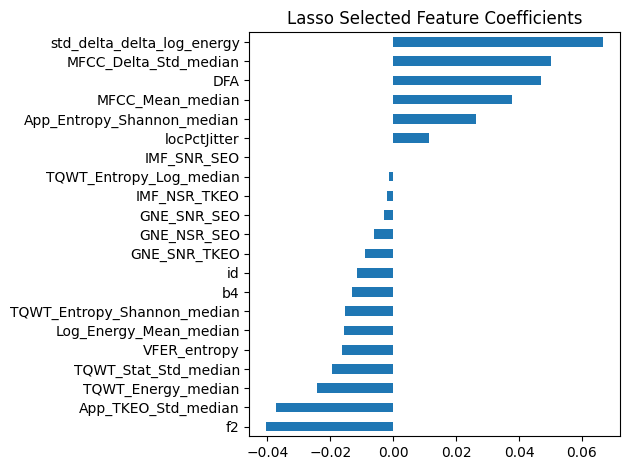

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

coef_df = pd.Series(coef, index=X.columns)
coef_df[coef_df != 0].sort_values().plot(kind='barh', title='Lasso Selected Feature Coefficients')
plt.tight_layout()
plt.show()

# Ensemble approach: Random Forest, ANOVA F-test, Lasso Regression

In [20]:
# STEP 1: Prepare data
df = pd.read_csv("parkinson_disease_reduced.csv")
X = df.drop(columns=["class"])
y = df["class"]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_cols = X.columns


rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)
rf_importance = pd.Series(rf.feature_importances_, index=X_cols).sort_values(ascending=False)

selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_scaled, y)
anova_scores = pd.Series(selector.scores_, index=X_cols).sort_values(ascending=False)

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)
lasso_coef = pd.Series(np.abs(lasso.coef_), index=X_cols).sort_values(ascending=False)

def get_top_k_features(series, k):
    return list(series.head(k).index)

top_k_values = [10, 20, 50]
feature_sets = {}

for k in top_k_values:
    feature_sets[f"top_{k}_rf"] = get_top_k_features(rf_importance, k)
    feature_sets[f"top_{k}_anova"] = get_top_k_features(anova_scores, k)
    feature_sets[f"top_{k}_lasso"] = get_top_k_features(lasso_coef, k)

# Ensemble approach: Union of all selected features

In [21]:
# Print selected features
#for key, features in feature_sets.items():
    #print(f"\n {key}:")
    #print(features)

# Optional: check intersection
for k in top_k_values:
    overlap = set(feature_sets[f"top_{k}_rf"]) & set(feature_sets[f"top_{k}_anova"]) & set(feature_sets[f"top_{k}_lasso"])
    print(f"\n Features selected by ALL 3 methods (top {k}): {len(overlap)}")
    print(sorted(list(overlap)))



 Features selected by ALL 3 methods (top 10): 1
['std_delta_delta_log_energy']

 Features selected by ALL 3 methods (top 20): 5
['App_Entropy_Shannon_median', 'MFCC_Delta_Std_median', 'TQWT_Entropy_Shannon_median', 'f2', 'std_delta_delta_log_energy']

 Features selected by ALL 3 methods (top 50): 20
['App_Entropy_Log_median', 'App_Entropy_Shannon_median', 'App_TKEO_Mean_median', 'App_TKEO_Std_median', 'DFA', 'GNE_SNR_SEO', 'IMF_SNR_SEO', 'Log_Energy_Mean_median', 'Log_Energy_Std_median', 'MFCC_Delta_Std_median', 'MFCC_Mean_median', 'TQWT_Entropy_Log_median', 'TQWT_Entropy_Shannon_median', 'TQWT_Stat_Max_median', 'TQWT_Stat_Std_median', 'VFER_entropy', 'f2', 'locPctJitter', 'std_Log_energy', 'std_delta_delta_log_energy']


# Ensemble approach: Majority Vote-Based Feature Selection

In [22]:
# Step 3: Majority voting logic
def get_top_k(series, k):
    return set(series.head(k).index)

def majority_vote_selection(k):
    rf_top = get_top_k(rf_importance, k)
    anova_top = get_top_k(anova_scores, k)
    lasso_top = get_top_k(lasso_coef, k)

    all_features = list(set(rf_top) | set(anova_top) | set(lasso_top))
    
    # Count how many methods selected each feature
    votes = {}
    for f in all_features:
        votes[f] = int(f in rf_top) + int(f in anova_top) + int(f in lasso_top)

    # Keep only those with at least 2 votes
    selected = [f for f, v in votes.items() if v >= 2]
    return selected

# Step 4: Run for k = 10, 20, 50
selected_features_dict = {}
for k in [10, 20, 50]:
    selected_features = majority_vote_selection(k)
    selected_features_dict[f"top_{k}_majority"] = selected_features
    print(f"\n Top {k} features by majority vote ({len(selected_features)} selected):")
    print(selected_features)


 Top 10 features by majority vote (8 selected):
['VFER_entropy', 'TQWT_Entropy_Shannon_median', 'MFCC_Mean_median', 'minIntensity', 'App_Entropy_Shannon_median', 'MFCC_Delta_Std_median', 'std_delta_delta_log_energy', 'DFA']

 Top 20 features by majority vote (17 selected):
['Log_Energy_Std_median', 'MFCC_Mean_median', 'minIntensity', 'TQWT_Energy_median', 'MFCC_Delta_Std_median', 'App_Entropy_Log_median', 'f1', 'VFER_entropy', 'TQWT_Entropy_Shannon_median', 'TQWT_Entropy_Log_median', 'id', 'App_Entropy_Shannon_median', 'apq11Shimmer', 'numPulses', 'std_delta_delta_log_energy', 'f2', 'DFA']

 Top 50 features by majority vote (50 selected):
['Log_Energy_Std_median', 'TQWT_TKEO_Mean_median', 'App_TKEO_Std_median', 'TQWT_Energy_median', 'GNE_SNR_SEO', 'locDbShimmer', 'IMF_SNR_entropy', 'maxIntensity', 'ppq5Jitter', 'locAbsJitter', 'ddpJitter', 'App_TKEO_Mean_median', 'TQWT_Entropy_Log_median', 'meanIntensity', 'rapJitter', 'App_Entropy_Shannon_median', 'TQWT_Stat_Min_median', 'IMF_SNR_SEO

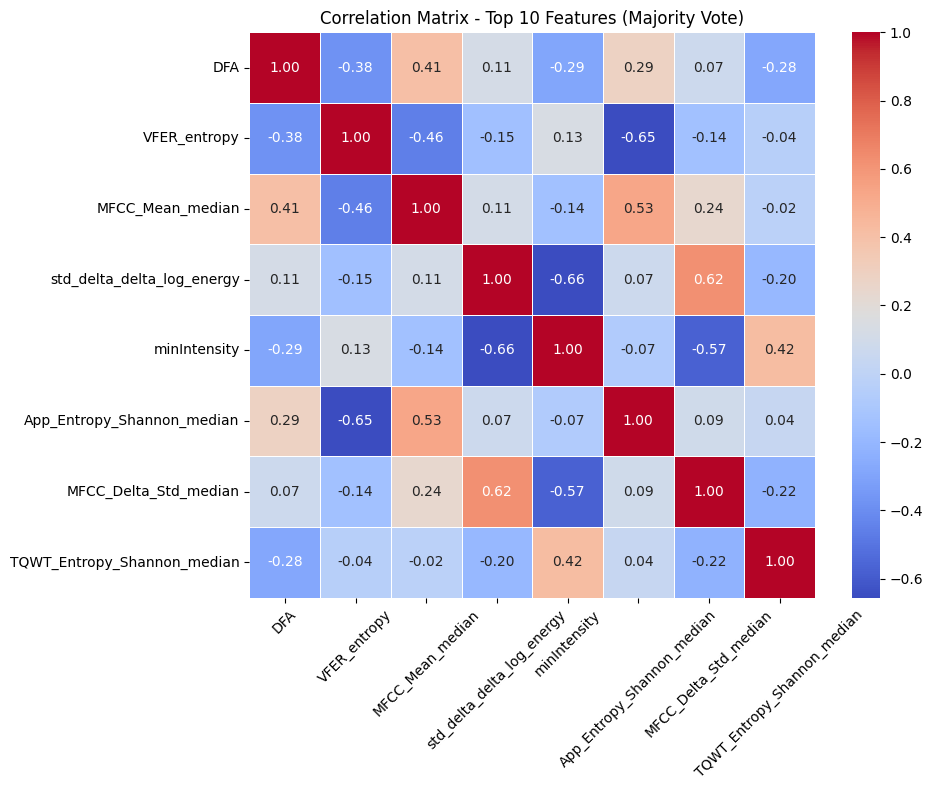

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load reduced dataset (with median-aggregated features)
df = pd.read_csv("parkinson_disease_reduced.csv")  # Make sure it has the selected features

# Top 10 majority-vote features (8 selected)
top10_majority_features = [
    'DFA', 'VFER_entropy', 'MFCC_Mean_median', 'std_delta_delta_log_energy',
    'minIntensity', 'App_Entropy_Shannon_median',
    'MFCC_Delta_Std_median', 'TQWT_Entropy_Shannon_median'
]

# Subset the data
df_top10 = df[top10_majority_features]

# Compute correlation matrix
corr_matrix = df_top10.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix - Top 10 Features (Majority Vote)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Phase 0 & 0a
# Model traning without and with SMOTE for all 754 features 

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

# ---------------------------
# Step 1: Load full dataset
# ---------------------------
df = pd.read_csv("parkinson_disease.csv")
X = df.drop(columns=["class"])
y = df["class"]

# ---------------------------
# Step 2: Train-test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ---------------------------
# Step 3: Define models
# ---------------------------
models = {
    "LogisticRegression_L2": LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
    "SVM_RBF": SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# ---------------------------
# Step 4: Define metrics
# ---------------------------
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# ---------------------------
# Phase 0: Full train set (original distribution)
# ---------------------------
results_phase0 = {}
for name, model in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring, n_jobs=1)
    results_phase0[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

df_results_phase0 = pd.DataFrame(results_phase0).T
print(" Phase 0 - Cross-Validation Results (Original Full Dataset):")
print(df_results_phase0)

# ---------------------------
# Phase 0a: Full train set with SMOTE
# ---------------------------
X_train_scaled = StandardScaler().fit_transform(X_train)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

results_phase0a = {}
for name, model in models.items():
    scores = cross_validate(model, X_resampled, y_resampled, cv=5, scoring=scoring, n_jobs=1)
    results_phase0a[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

df_results_phase0a = pd.DataFrame(results_phase0a).T
print("\n Phase 0a - Cross-Validation Results (SMOTE-Resampled Full Dataset):")
print(df_results_phase0a)


 Phase 0 - Cross-Validation Results (Original Full Dataset):
                       accuracy        f1  precision    recall
LogisticRegression_L2  0.814545  0.874013   0.887254  0.862662
RandomForest           0.869105  0.917447   0.869944  0.971209
SVM_RBF                0.857562  0.911796   0.849427  0.984469
NeuralNetwork          0.864215  0.912513   0.881541  0.946764

 Phase 0a - Cross-Validation Results (SMOTE-Resampled Full Dataset):
                       accuracy        f1  precision    recall
LogisticRegression_L2  0.903616  0.895241   0.979255  0.824957
RandomForest           0.941271  0.939390   0.972826  0.909060
SVM_RBF                0.941283  0.940969   0.952584  0.931209
NeuralNetwork          0.953462  0.952003   0.983908  0.922369


# Helper function to plot ROC

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_auc(models, X, y, title, scaled=False):
    plt.figure(figsize=(10, 8))

    if not scaled:
        X = StandardScaler().fit_transform(X)

    for name, model in models.items():
        # Scale internally only if not already scaled
        pipe = Pipeline([('scaler', StandardScaler()), ('model', model)]) if not scaled else model

        y_proba = cross_val_predict(pipe, X, y, cv=5, method='predict_proba')[:, 1]
        fpr, tpr, _ = roc_curve(y, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.title(f"ROC Curve - {title}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()


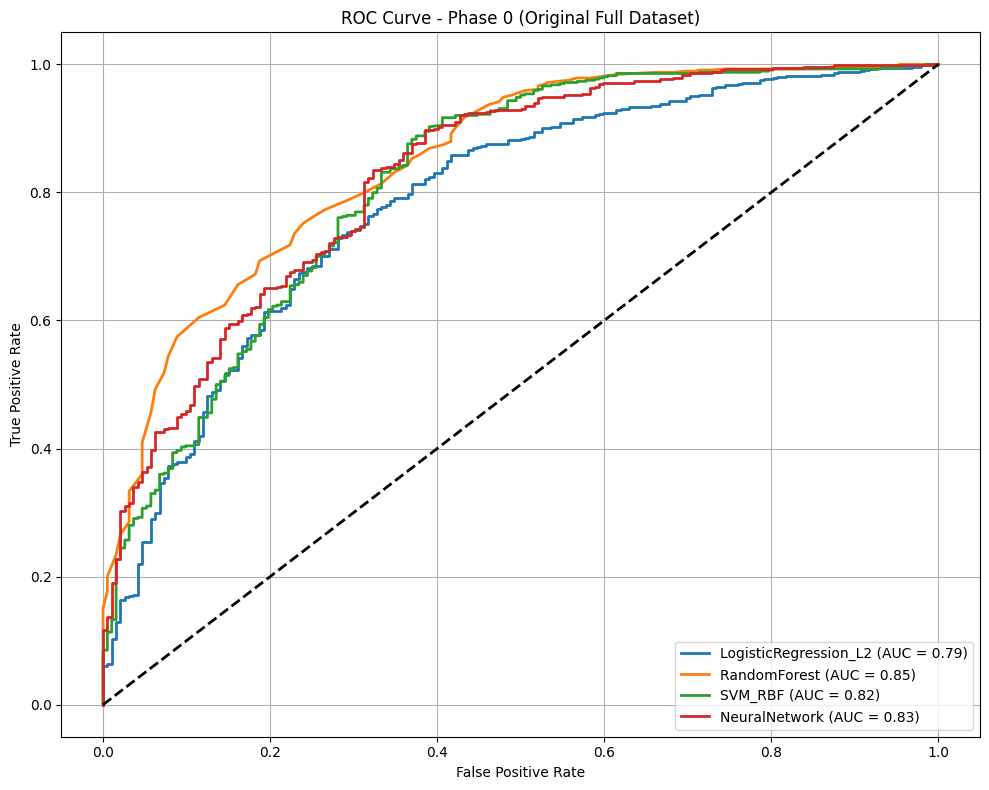

In [26]:
# Phase 0: original full dataset
df0 = pd.read_csv("parkinson_disease.csv")
X0 = df0.drop(columns=["class"])
y0 = df0["class"]

plot_roc_auc(models, X0, y0, title="Phase 0 (Original Full Dataset)", scaled=False)


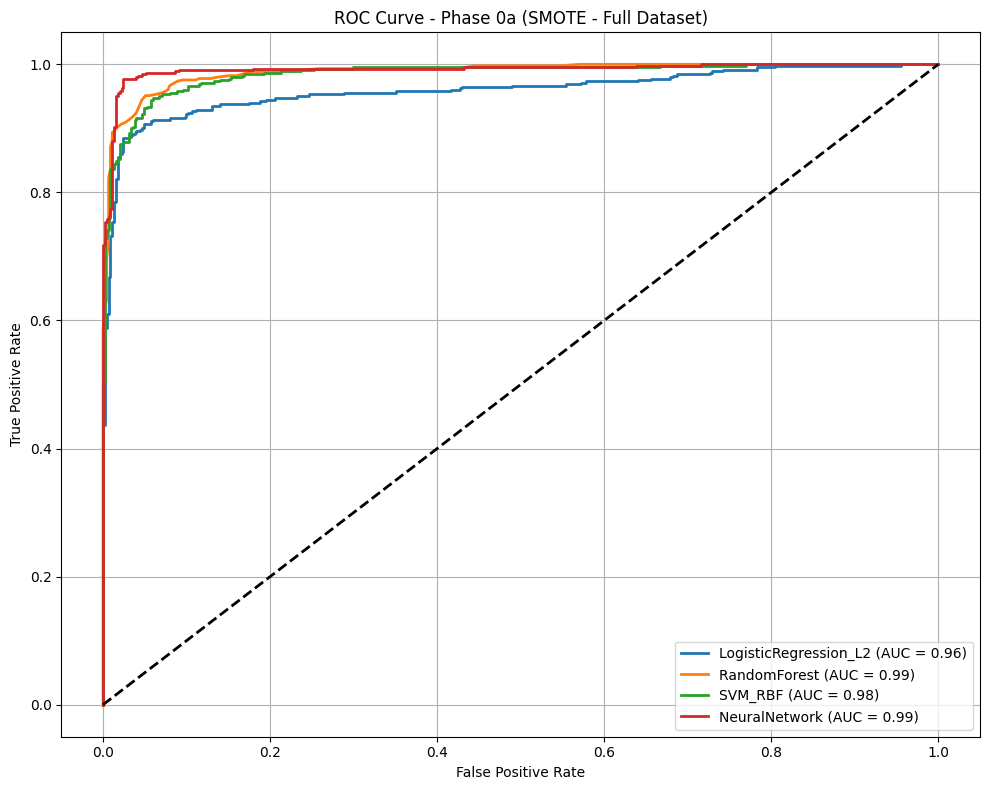

In [27]:
X0_train, _, y0_train, _ = train_test_split(X0, y0, stratify=y0, test_size=0.2, random_state=42)
X0_train_scaled = StandardScaler().fit_transform(X0_train)
X0_resampled, y0_resampled = SMOTE(random_state=42).fit_resample(X0_train_scaled, y0_train)

plot_roc_auc(models, X0_resampled, y0_resampled, title="Phase 0a (SMOTE - Full Dataset)", scaled=True)


# Phase 1 & 1a
# Model traning without and with SMOTE for Reduced features (92 features)

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

# ---------------------------
# Step 1: Load dataset
# ---------------------------
df = pd.read_csv("parkinson_disease_reduced.csv")
X = df.drop(columns=["class"])
y = df["class"]

# ---------------------------
# Step 2: Train-test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ---------------------------
# Step 3: Define models
# ---------------------------
models = {
    "LogisticRegression_L2": LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
    "SVM_RBF": SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

# ---------------------------
# Step 4: Define metrics
# ---------------------------
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# ---------------------------
# Phase 1: No SMOTE
# ---------------------------
results_phase1 = {}
for name, model in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring, n_jobs=1)
    results_phase1[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

df_results_phase1 = pd.DataFrame(results_phase1).T
print("Phase 1 - Cross-Validation Results (Original Train Set):")
print(df_results_phase1)

# ---------------------------
# Phase 1a: With SMOTE
# ---------------------------
X_train_scaled = StandardScaler().fit_transform(X_train)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

results_phase1a = {}
for name, model in models.items():
    scores = cross_validate(model, X_resampled, y_resampled, cv=5, scoring=scoring, n_jobs=1)
    results_phase1a[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

df_results_phase1a = pd.DataFrame(results_phase1a).T
print("\nPhase 1a - Cross-Validation Results (SMOTE-Resampled Train Set):")
print(df_results_phase1a)


Phase 1 - Cross-Validation Results (Original Train Set):
                       accuracy        f1  precision    recall
LogisticRegression_L2  0.779793  0.854426   0.845139  0.864786
RandomForest           0.841019  0.899877   0.851111  0.955653
SVM_RBF                0.817810  0.886327   0.832302  0.948962
NeuralNetwork          0.822796  0.884688   0.862070  0.909035

Phase 1a - Cross-Validation Results (SMOTE-Resampled Train Set):
                       accuracy        f1  precision    recall
LogisticRegression_L2  0.820436  0.812669   0.853133  0.778242
RandomForest           0.914635  0.910683   0.950717  0.875726
SVM_RBF                0.885826  0.875631   0.958193  0.809182
NeuralNetwork          0.920221  0.916383   0.967540  0.871331


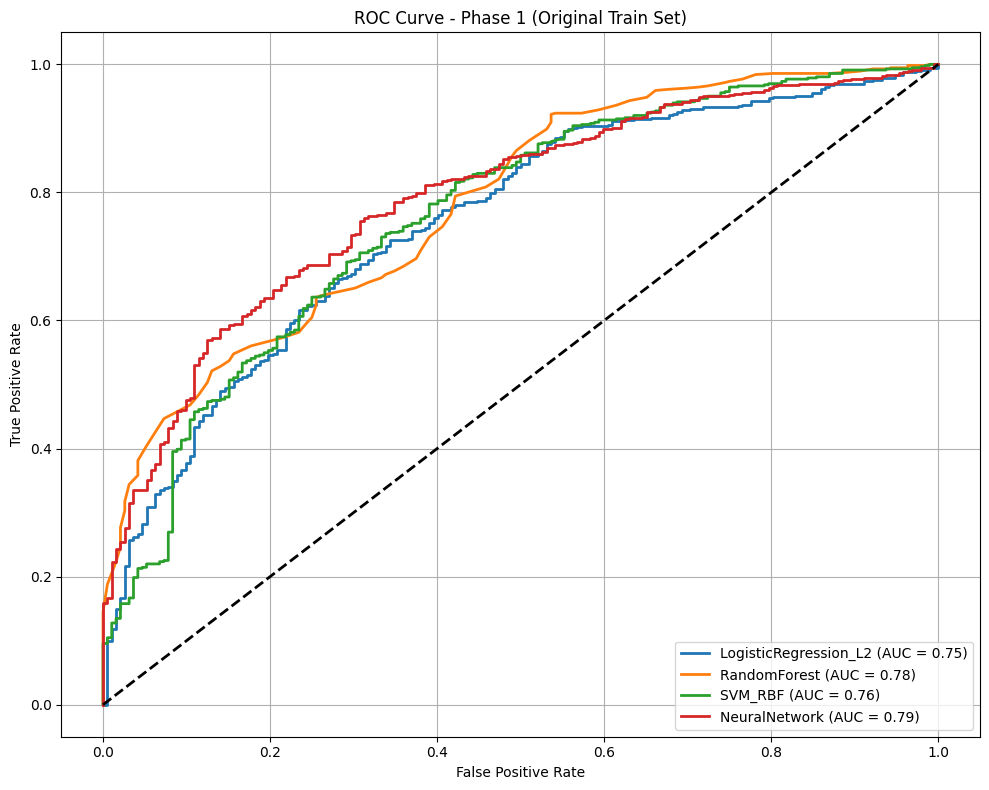

In [29]:
# Load reduced dataset for Phase 1
df1 = pd.read_csv("parkinson_disease_reduced.csv")
X1 = df1.drop(columns=["class"])
y1 = df1["class"]

plot_roc_auc(models, X1, y1, title="Phase 1 (Original Train Set)", scaled=False)


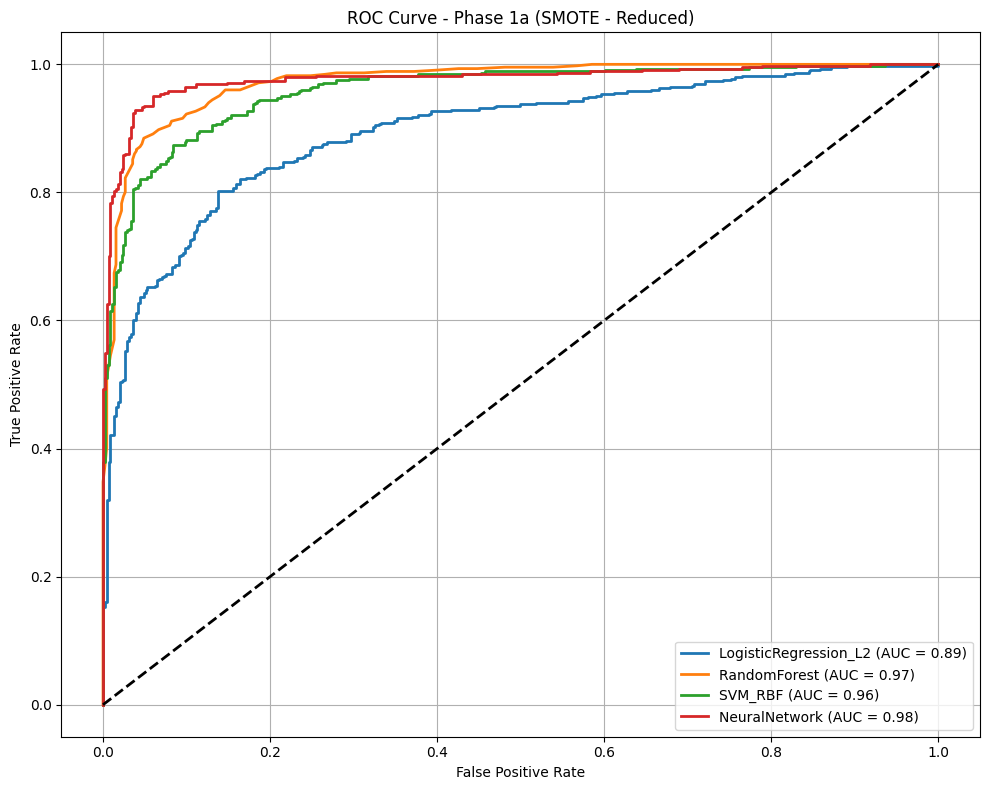

In [30]:
X1_train, _, y1_train, _ = train_test_split(X1, y1, stratify=y1, test_size=0.2, random_state=42)
X1_train_scaled = StandardScaler().fit_transform(X1_train)
X1_resampled, y1_resampled = SMOTE(random_state=42).fit_resample(X1_train_scaled, y1_train)

plot_roc_auc(models, X1_resampled, y1_resampled, title="Phase 1a (SMOTE - Reduced)", scaled=True)


# Phase 2 & 2a
# Model traning without and with SMOTE for Reduced features (20 features)

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LassoCV
from imblearn.over_sampling import SMOTE

# ---------------------------------------------
# Step 1: Load and prepare data
# ---------------------------------------------
df = pd.read_csv("parkinson_disease_reduced.csv")
X = df.drop(columns=["class"])
y = df["class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_cols = X.columns

# Feature selection using top 50 from each method
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)
rf_importance = pd.Series(rf.feature_importances_, index=X_cols).sort_values(ascending=False)

anova = SelectKBest(score_func=f_classif, k='all')
anova.fit(X_scaled, y)
anova_scores = pd.Series(anova.scores_, index=X_cols).sort_values(ascending=False)

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)
lasso_coef = pd.Series(np.abs(lasso.coef_), index=X_cols).sort_values(ascending=False)

def get_top_k(series, k): return list(series.head(k).index)

rf_top = set(get_top_k(rf_importance, 50))
anova_top = set(get_top_k(anova_scores, 50))
lasso_top = set(get_top_k(lasso_coef, 50))

intersection = list(rf_top & anova_top & lasso_top)  # final features for Phase 2

print('No of features: ', len(intersection))

X_selected = X[intersection]

# ---------------------------------------------
# Step 2: Train-test split
# ---------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, stratify=y, test_size=0.2, random_state=42)

# ---------------------------------------------
# Step 3: Define models
# ---------------------------------------------
models = {
    "LogisticRegression_L2": LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM_RBF": SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# ---------------------------------------------
# Phase 2: Original Train Set
# ---------------------------------------------
results_phase2 = {}
for name, model in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring, n_jobs=1)
    results_phase2[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

df_results_phase2 = pd.DataFrame(results_phase2).T
print("Phase 2 Results (Original Train Set):")
print(df_results_phase2)

# ---------------------------------------------
# Phase 2a: SMOTE-resampled Train Set
# ---------------------------------------------
X_train_scaled = StandardScaler().fit_transform(X_train)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

results_phase2a = {}
for name, model in models.items():
    scores = cross_validate(model, X_resampled, y_resampled, cv=5, scoring=scoring, n_jobs=1)
    results_phase2a[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

df_results_phase2a = pd.DataFrame(results_phase2a).T
print("\n Phase 2a Results (SMOTE-Resampled Train Set):")
print(df_results_phase2a)



No of features:  20
Phase 2 Results (Original Train Set):
                       accuracy        f1  precision    recall
LogisticRegression_L2  0.831061  0.892213   0.852879  0.935653
RandomForest           0.845964  0.901569   0.865112  0.942344
SVM_RBF                0.826088  0.891050   0.838465  0.951209
NeuralNetwork          0.844311  0.897388   0.884235  0.911282

 Phase 2a Results (SMOTE-Resampled Train Set):
                       accuracy        f1  precision    recall
LogisticRegression_L2  0.797090  0.787636   0.825472  0.756044
RandomForest           0.901369  0.899537   0.919373  0.882369
SVM_RBF                0.838122  0.829525   0.875841  0.789255
NeuralNetwork          0.919091  0.915117   0.966263  0.871306


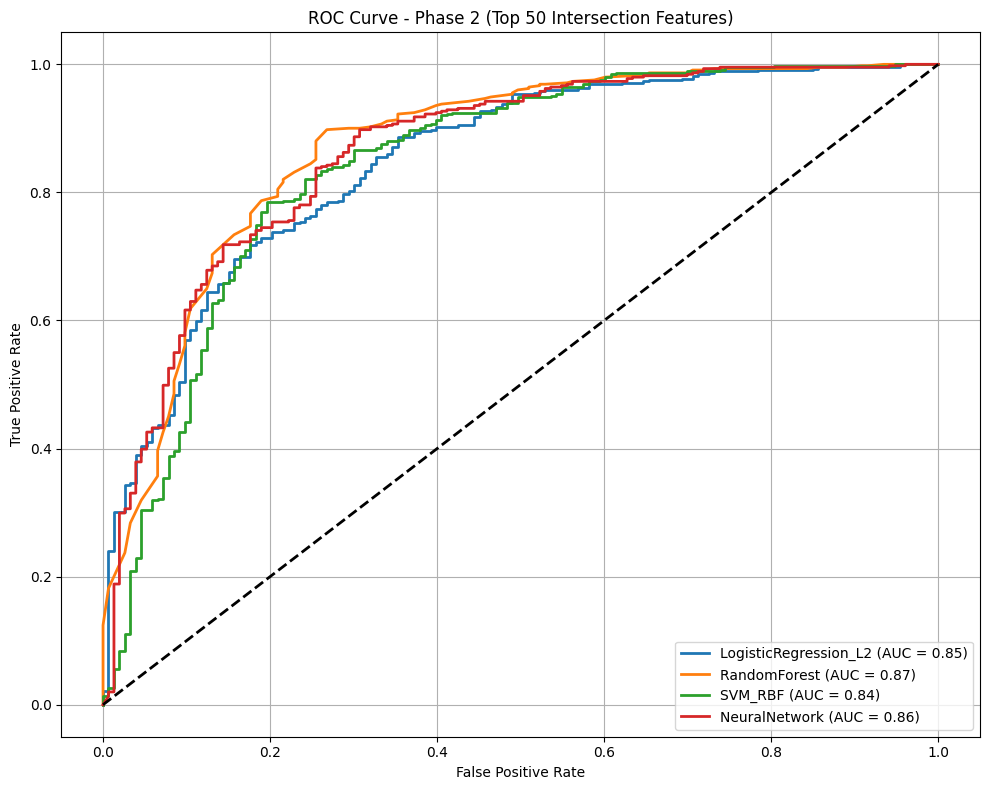

In [32]:
plot_roc_auc(models, X_train, y_train, title="Phase 2 (Top 50 Intersection Features)", scaled=False)

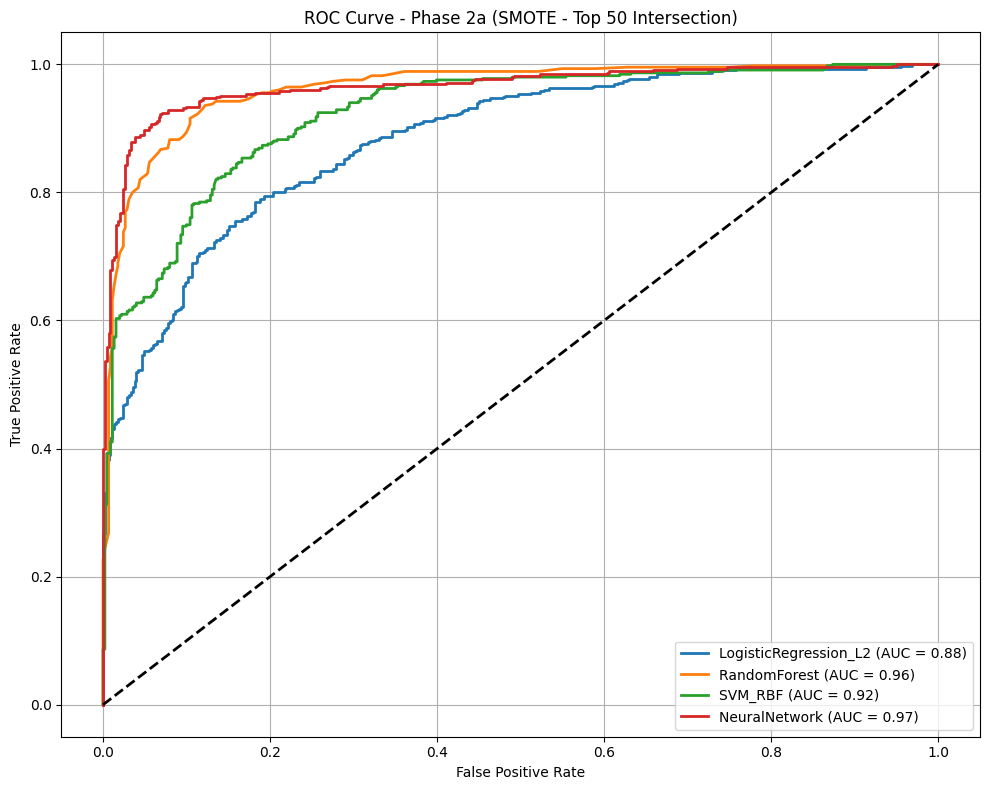

In [33]:
plot_roc_auc(models, X_resampled, y_resampled, title="Phase 2a (SMOTE - Top 50 Intersection)", scaled=True)

# Phase 3 & 3a
# Model traning without and with SMOTE for Reduced features (50 features)

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LassoCV
from imblearn.over_sampling import SMOTE

# ---------------------------------------------
# Step 1: Load and prepare data
# ---------------------------------------------
df = pd.read_csv("parkinson_disease_reduced.csv")
X = df.drop(columns=["class"])
y = df["class"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_cols = X.columns

# Feature importances
rf = RandomForestClassifier(random_state=42)
rf.fit(X_scaled, y)
rf_importance = pd.Series(rf.feature_importances_, index=X_cols).sort_values(ascending=False)

anova = SelectKBest(score_func=f_classif, k='all')
anova.fit(X_scaled, y)
anova_scores = pd.Series(anova.scores_, index=X_cols).sort_values(ascending=False)

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)
lasso_coef = pd.Series(np.abs(lasso.coef_), index=X_cols).sort_values(ascending=False)

# Majority vote function
def get_top_k(series, k):
    return set(series.head(k).index)

def majority_vote_selection(k):
    rf_top = get_top_k(rf_importance, k)
    anova_top = get_top_k(anova_scores, k)
    lasso_top = get_top_k(lasso_coef, k)
    all_features = list(set(rf_top) | set(anova_top) | set(lasso_top))
    votes = {f: int(f in rf_top) + int(f in anova_top) + int(f in lasso_top) for f in all_features}
    selected = [f for f, v in votes.items() if v >= 2]
    return selected

# Select features for k=50
majority_features = majority_vote_selection(50)
X_majority = X[majority_features]

print('No of Features: ', len(majority_features))

# ---------------------------------------------
# Step 2: Train-test split
# ---------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_majority, y, stratify=y, test_size=0.2, random_state=42)

# ---------------------------------------------
# Step 3: Define models
# ---------------------------------------------
models = {
    "LogisticRegression_L2": LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM_RBF": SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# ---------------------------------------------
# Phase 3: Original Train Set
# ---------------------------------------------
results_phase3 = {}
for name, model in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    scores = cross_validate(pipe, X_train, y_train, cv=5, scoring=scoring, n_jobs=1)
    results_phase3[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

df_results_phase3 = pd.DataFrame(results_phase3).T
print("Phase 3 Results (Original Train Set - Majority Vote Features):")
print(df_results_phase3)

# ---------------------------------------------
# Phase 3a: SMOTE-resampled Train Set
# ---------------------------------------------
X_train_scaled = StandardScaler().fit_transform(X_train)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train_scaled, y_train)

results_phase3a = {}
for name, model in models.items():
    scores = cross_validate(model, X_resampled, y_resampled, cv=5, scoring=scoring, n_jobs=1)
    results_phase3a[name] = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}

df_results_phase3a = pd.DataFrame(results_phase3a).T
print("\nPhase 3a Results (SMOTE-Resampled Train Set - Majority Vote Features):")
print(df_results_phase3a)


No of Features:  50
Phase 3 Results (Original Train Set - Majority Vote Features):
                       accuracy        f1  precision    recall
LogisticRegression_L2  0.797975  0.867318   0.851534  0.884664
RandomForest           0.845992  0.902115   0.860472  0.948962
SVM_RBF                0.826116  0.891629   0.836101  0.955629
NeuralNetwork          0.826116  0.885484   0.869651  0.904615

Phase 3a Results (SMOTE-Resampled Train Set - Majority Vote Features):
                       accuracy        f1  precision    recall
LogisticRegression_L2  0.789319  0.777241   0.825418  0.736093
RandomForest           0.913524  0.909592   0.951386  0.873480
SVM_RBF                0.842517  0.822918   0.928486  0.744835
NeuralNetwork          0.931289  0.927685   0.974752  0.886862


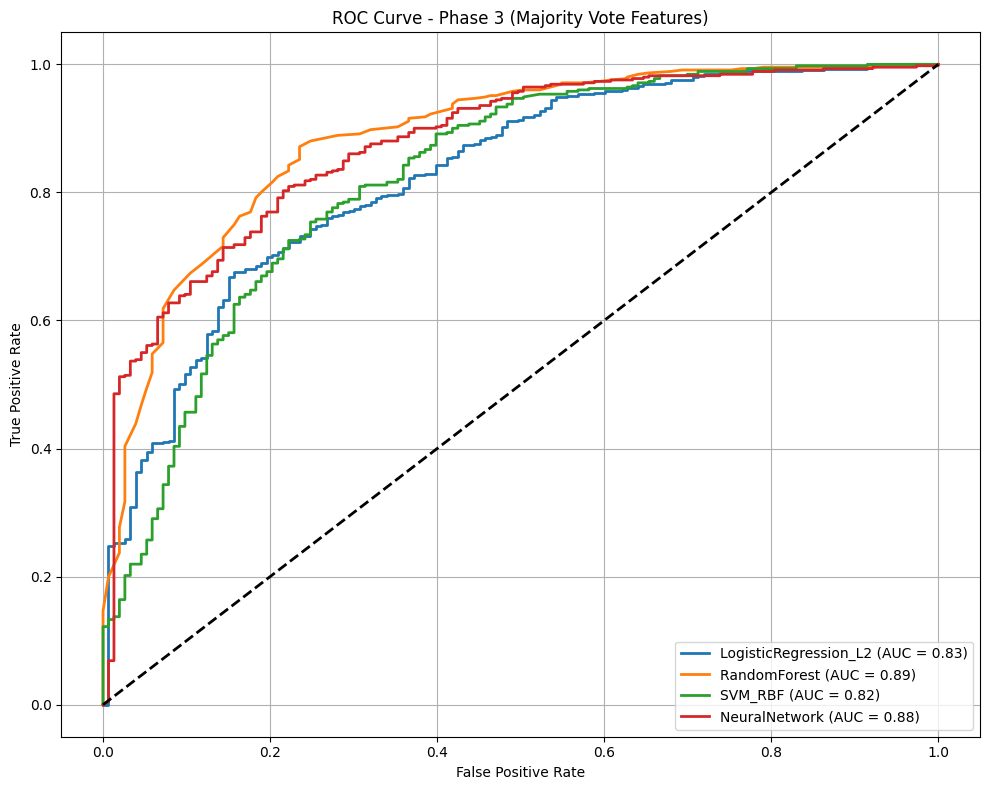

In [35]:
plot_roc_auc(models, X_train, y_train, title="Phase 3 (Majority Vote Features)", scaled=False)

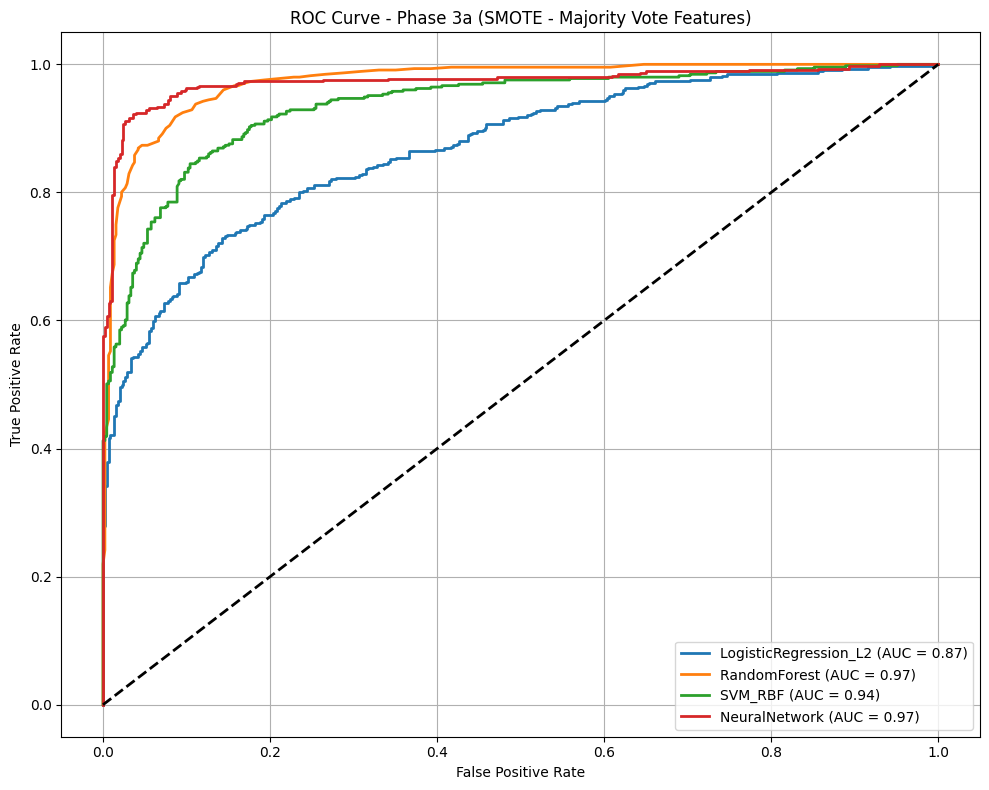

In [36]:
plot_roc_auc(models, X_resampled, y_resampled, title="Phase 3a (SMOTE - Majority Vote Features)", scaled=True)

# Performance visualization

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# All results dictionary
all_results = {
    "Phase 0": {
        "LogisticRegression_L2": [0.8145, 0.8740, 0.8873, 0.8627],
        "RandomForest": [0.8691, 0.9174, 0.8699, 0.9712],
        "SVM_RBF": [0.8576, 0.9118, 0.8494, 0.9845],
        "NeuralNetwork": [0.8642, 0.9125, 0.8815, 0.9468],
    },
    "Phase 0a": {
        "LogisticRegression_L2": [0.9036, 0.8952, 0.9793, 0.8250],
        "RandomForest": [0.9413, 0.9394, 0.9728, 0.9091],
        "SVM_RBF": [0.9413, 0.9410, 0.9526, 0.9312],
        "NeuralNetwork": [0.9535, 0.9520, 0.9839, 0.9224],
    },
    "Phase 1": {
        "LogisticRegression_L2": [0.7798, 0.8544, 0.8451, 0.8648],
        "RandomForest": [0.8410, 0.8999, 0.8511, 0.9557],
        "SVM_RBF": [0.8178, 0.8863, 0.8323, 0.9490],
        "NeuralNetwork": [0.8228, 0.8847, 0.8621, 0.9090],
    },
    "Phase 1a": {
        "LogisticRegression_L2": [0.8204, 0.8127, 0.8531, 0.7782],
        "RandomForest": [0.9146, 0.9107, 0.9507, 0.8757],
        "SVM_RBF": [0.8858, 0.8756, 0.9582, 0.8092],
        "NeuralNetwork": [0.9202, 0.9164, 0.9675, 0.8713],
    },
    "Phase 2": {
        "LogisticRegression_L2": [0.8311, 0.8922, 0.8529, 0.9357],
        "RandomForest": [0.8311, 0.8926, 0.8523, 0.9379],
        "SVM_RBF": [0.8261, 0.8911, 0.8385, 0.9512],
        "NeuralNetwork": [0.8460, 0.8985, 0.8843, 0.9135],
    },
    "Phase 2a": {
        "LogisticRegression_L2": [0.7971, 0.7876, 0.8255, 0.7560],
        "RandomForest": [0.8925, 0.8898, 0.9212, 0.8625],
        "SVM_RBF": [0.8381, 0.8295, 0.8758, 0.7893],
        "NeuralNetwork": [0.9180, 0.9138, 0.9623, 0.8736],
    },
    "Phase 3": {
        "LogisticRegression_L2": [0.7980, 0.8673, 0.8515, 0.8847],
        "RandomForest": [0.8410, 0.8993, 0.8550, 0.9490],
        "SVM_RBF": [0.8261, 0.8916, 0.8361, 0.9556],
        "NeuralNetwork": [0.8327, 0.8903, 0.8760, 0.9068],
    },
    "Phase 3a": {
        "LogisticRegression_L2": [0.7893, 0.7772, 0.8254, 0.7361],
        "RandomForest": [0.9124, 0.9093, 0.9446, 0.8780],
        "SVM_RBF": [0.8425, 0.8229, 0.9285, 0.7448],
        "NeuralNetwork": [0.9302, 0.9263, 0.9790, 0.8802],
    },
}

metrics = ["accuracy", "f1", "precision", "recall"]
phases = list(all_results.keys())
models = list(next(iter(all_results.values())).keys())


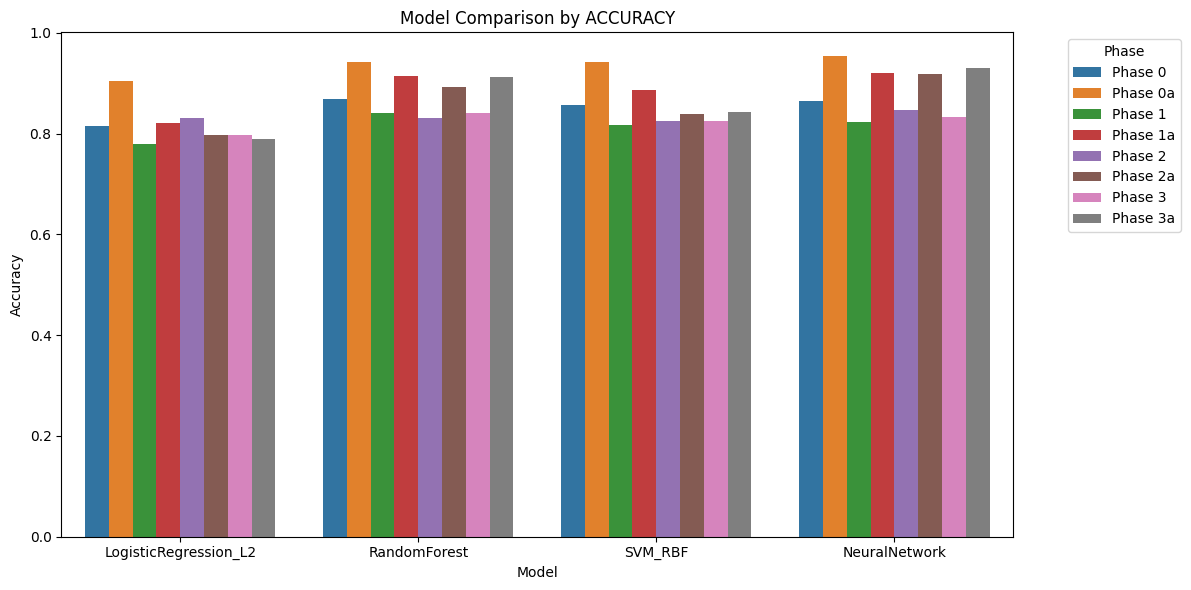

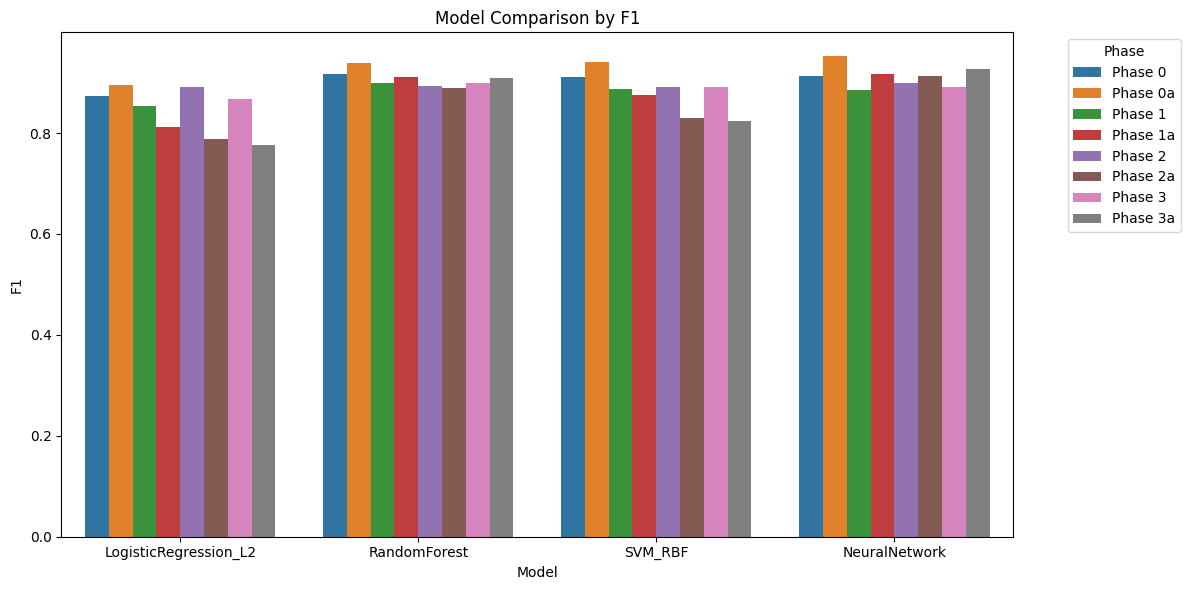

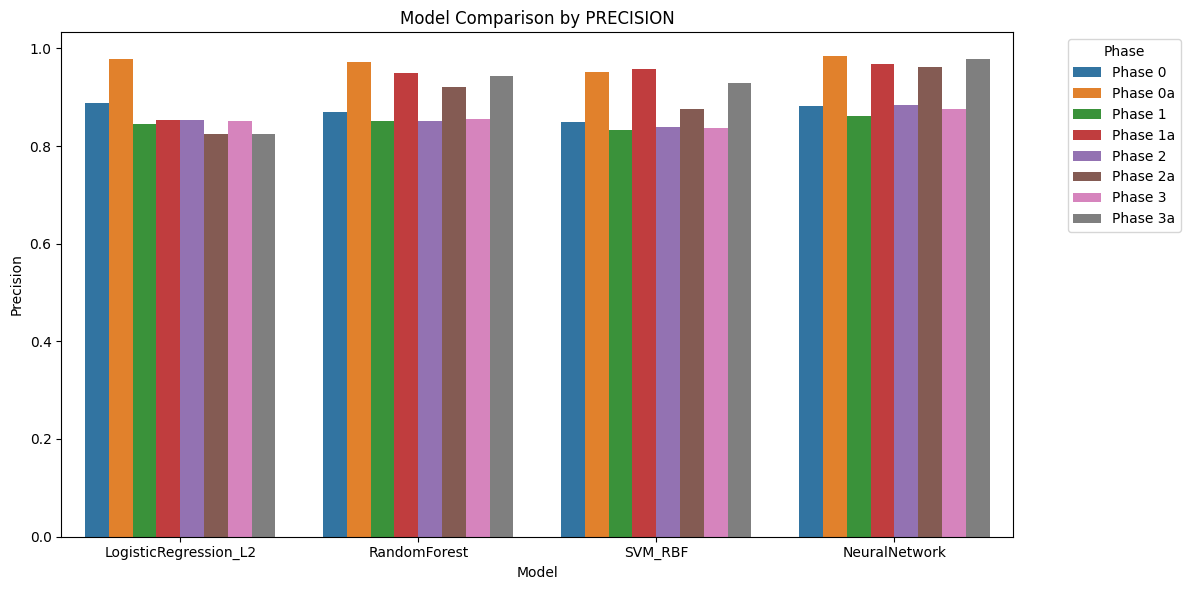

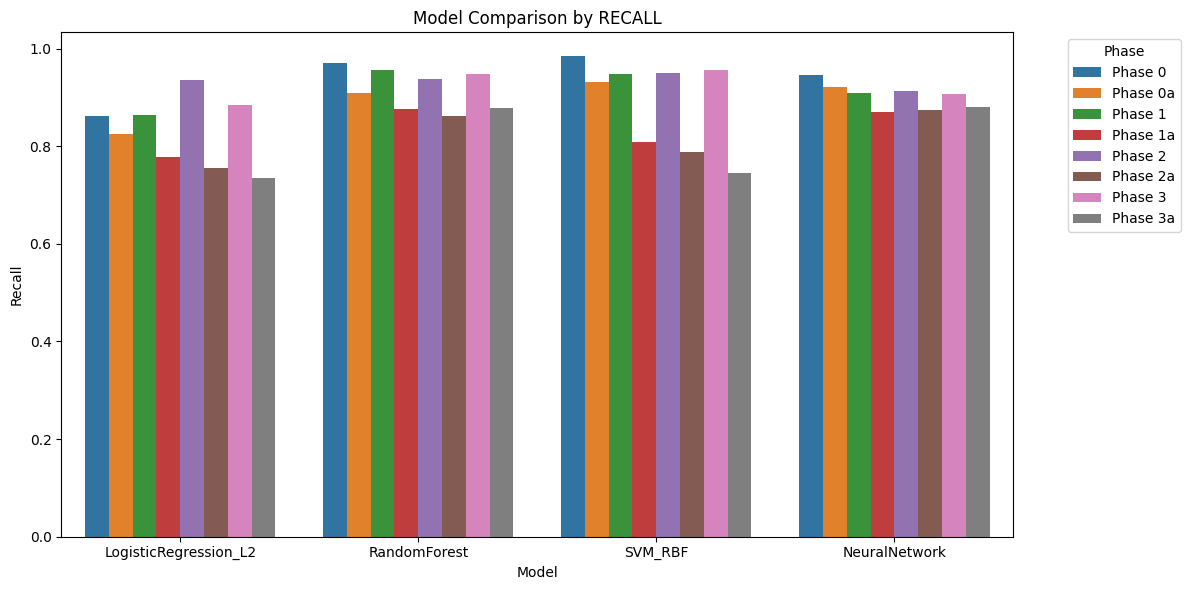

In [38]:
for i, metric in enumerate(metrics):
    metric_data = []

    for phase in phases:
        for model in models:
            value = all_results[phase][model][i]
            metric_data.append({"Phase": phase, "Model": model, metric: value})

    df_metric = pd.DataFrame(metric_data)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_metric, x="Model", y=metric, hue="Phase")
    plt.title(f"Model Comparison by {metric.upper()}")
    plt.ylabel(metric.capitalize())
    plt.legend(title="Phase", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


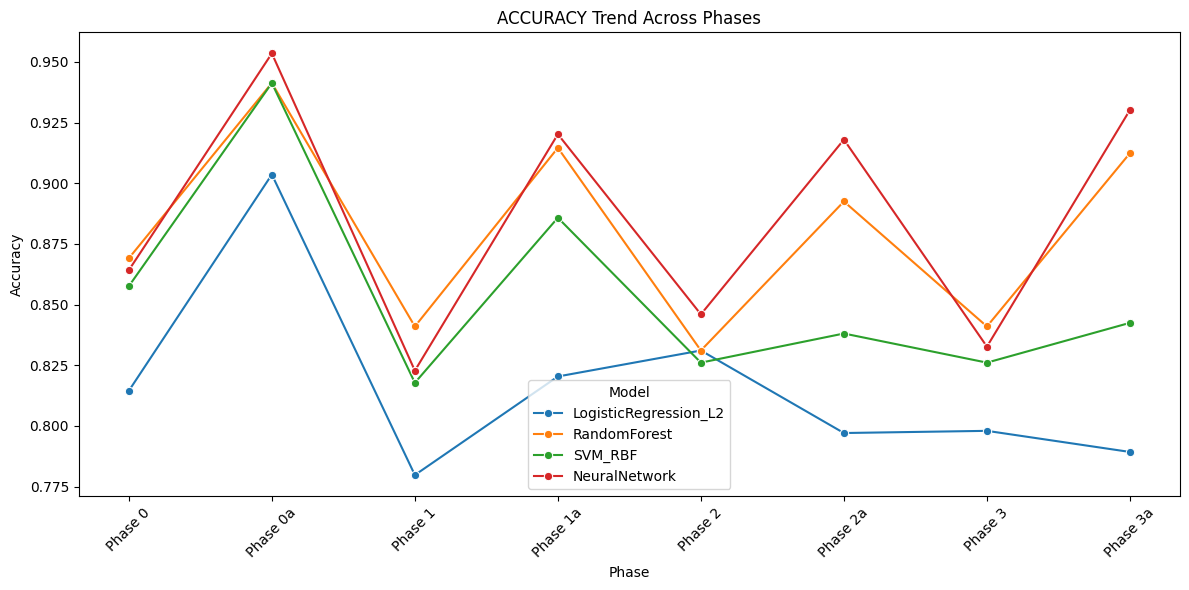

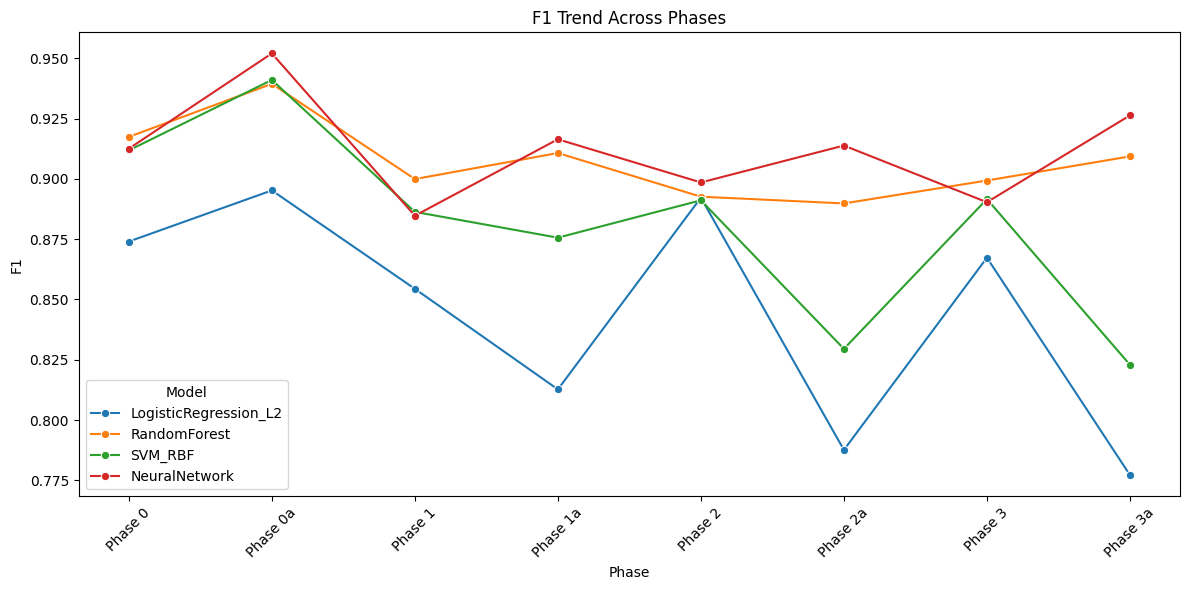

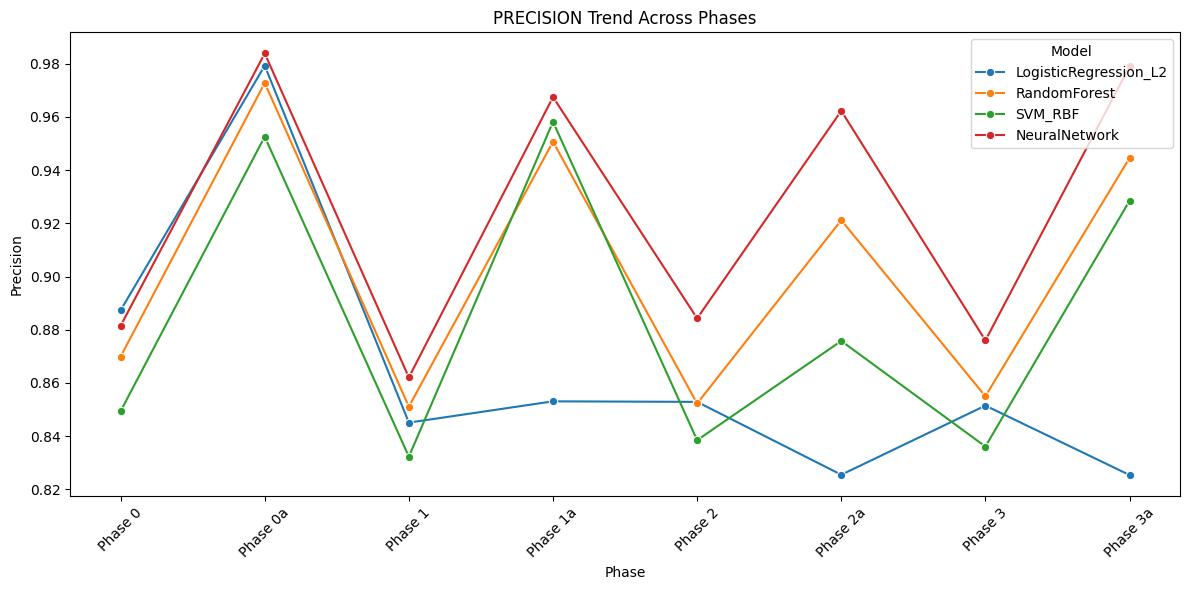

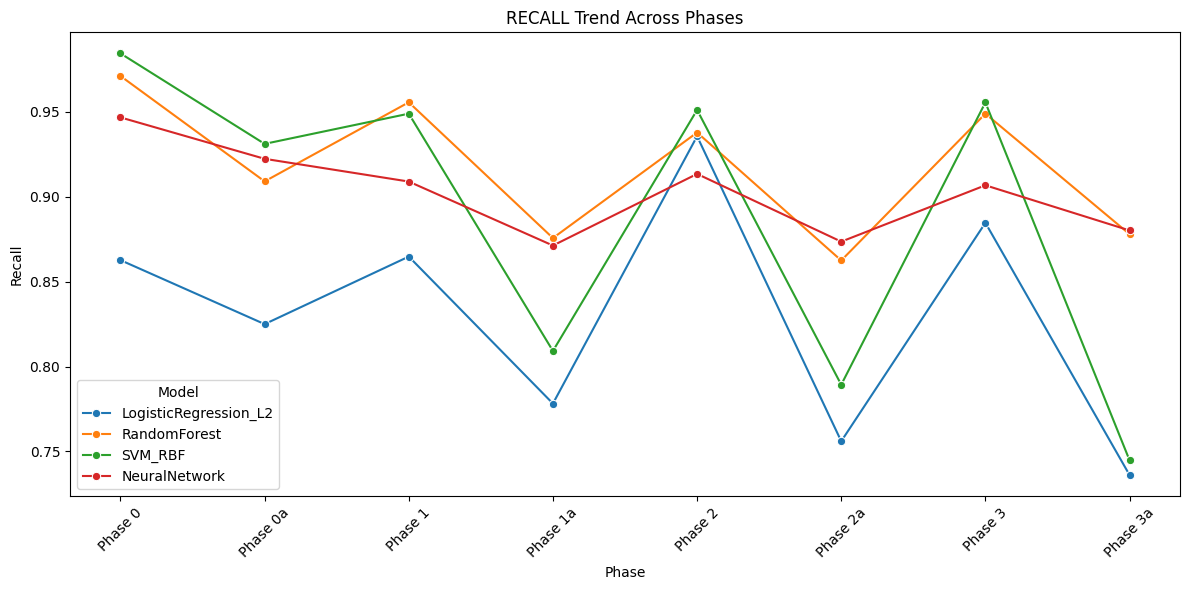

In [39]:
for i, metric in enumerate(metrics):
    trend_data = []

    for model in models:
        for phase in phases:
            value = all_results[phase][model][i]
            trend_data.append({"Phase": phase, "Model": model, metric: value})

    df_trend = pd.DataFrame(trend_data)

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_trend, x="Phase", y=metric, hue="Model", marker="o")
    plt.title(f"{metric.upper()} Trend Across Phases")
    plt.xticks(rotation=45)
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# All results dictionary
all_results = {
    "Phase 0": {
        "LogisticRegression_L2": [0.8145, 0.8740, 0.8873, 0.8627],
        "RandomForest": [0.8691, 0.9174, 0.8699, 0.9712],
        "SVM_RBF": [0.8576, 0.9118, 0.8494, 0.9845],
        "NeuralNetwork": [0.8642, 0.9125, 0.8815, 0.9468],
    },
    "Phase 0a": {
        "LogisticRegression_L2": [0.9036, 0.8952, 0.9793, 0.8250],
        "RandomForest": [0.9413, 0.9394, 0.9728, 0.9091],
        "SVM_RBF": [0.9413, 0.9410, 0.9526, 0.9312],
        "NeuralNetwork": [0.9535, 0.9520, 0.9839, 0.9224],
    },
    "Phase 1": {
        "LogisticRegression_L2": [0.7798, 0.8544, 0.8451, 0.8648],
        "RandomForest": [0.8410, 0.8999, 0.8511, 0.9557],
        "SVM_RBF": [0.8178, 0.8863, 0.8323, 0.9490],
        "NeuralNetwork": [0.8228, 0.8847, 0.8621, 0.9090],
    },
    "Phase 1a": {
        "LogisticRegression_L2": [0.8204, 0.8127, 0.8531, 0.7782],
        "RandomForest": [0.9146, 0.9107, 0.9507, 0.8757],
        "SVM_RBF": [0.8858, 0.8756, 0.9582, 0.8092],
        "NeuralNetwork": [0.9202, 0.9164, 0.9675, 0.8713],
    },
    "Phase 2": {
        "LogisticRegression_L2": [0.8311, 0.8922, 0.8529, 0.9357],
        "RandomForest": [0.8311, 0.8926, 0.8523, 0.9379],
        "SVM_RBF": [0.8261, 0.8911, 0.8385, 0.9512],
        "NeuralNetwork": [0.8460, 0.8985, 0.8843, 0.9135],
    },
    "Phase 2a": {
        "LogisticRegression_L2": [0.7971, 0.7876, 0.8255, 0.7560],
        "RandomForest": [0.8925, 0.8898, 0.9212, 0.8625],
        "SVM_RBF": [0.8381, 0.8295, 0.8758, 0.7893],
        "NeuralNetwork": [0.9180, 0.9138, 0.9623, 0.8736],
    },
    "Phase 3": {
        "LogisticRegression_L2": [0.7980, 0.8673, 0.8515, 0.8847],
        "RandomForest": [0.8410, 0.8993, 0.8550, 0.9490],
        "SVM_RBF": [0.8261, 0.8916, 0.8361, 0.9556],
        "NeuralNetwork": [0.8327, 0.8903, 0.8760, 0.9068],
    },
    "Phase 3a": {
        "LogisticRegression_L2": [0.7893, 0.7772, 0.8254, 0.7361],
        "RandomForest": [0.9124, 0.9093, 0.9446, 0.8780],
        "SVM_RBF": [0.8425, 0.8229, 0.9285, 0.7448],
        "NeuralNetwork": [0.9302, 0.9263, 0.9790, 0.8802],
    },
}

metrics = ["accuracy", "f1", "precision", "recall"]
models = list(next(iter(all_results.values())).keys())

phases_base = [f"Phase {i}" for i in range(4)]
phases_smote = [f"Phase {i}a" for i in range(4)]


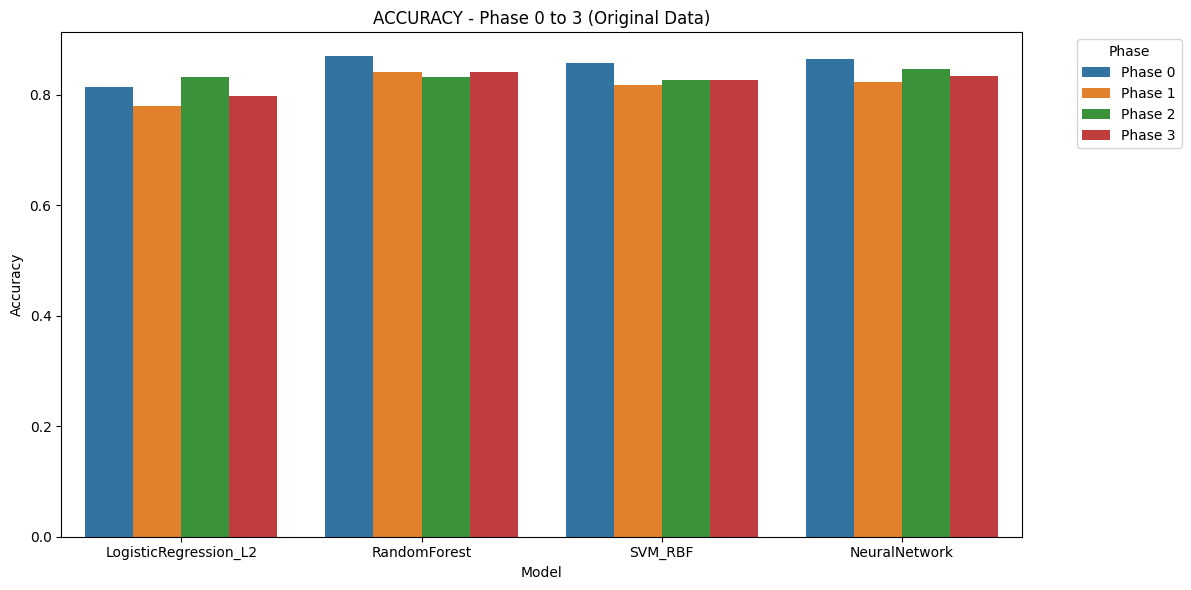

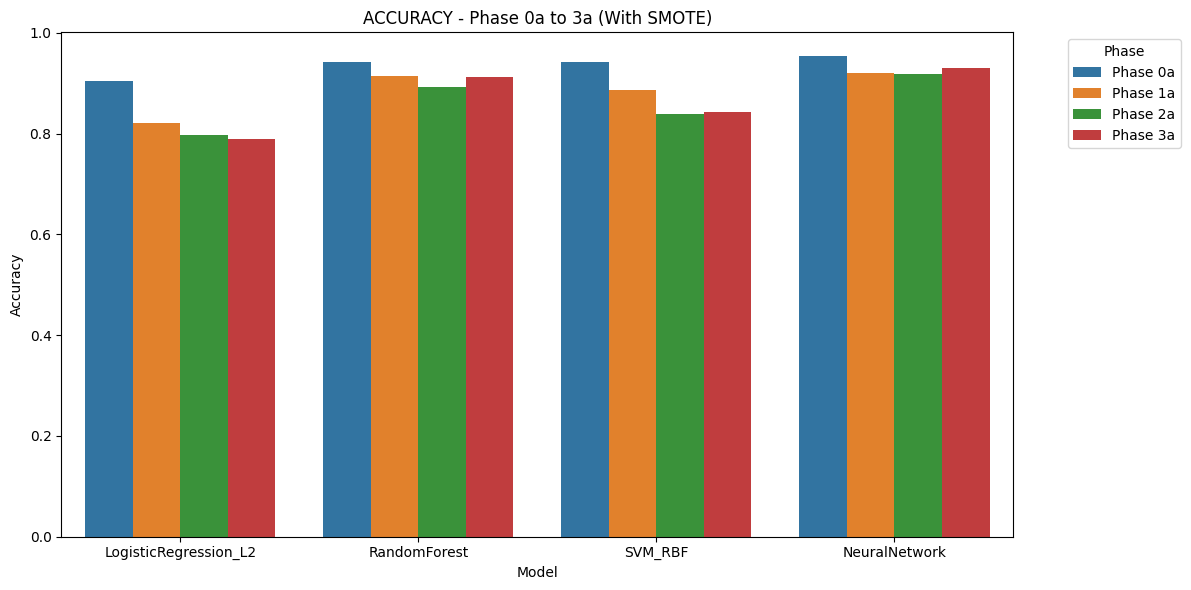

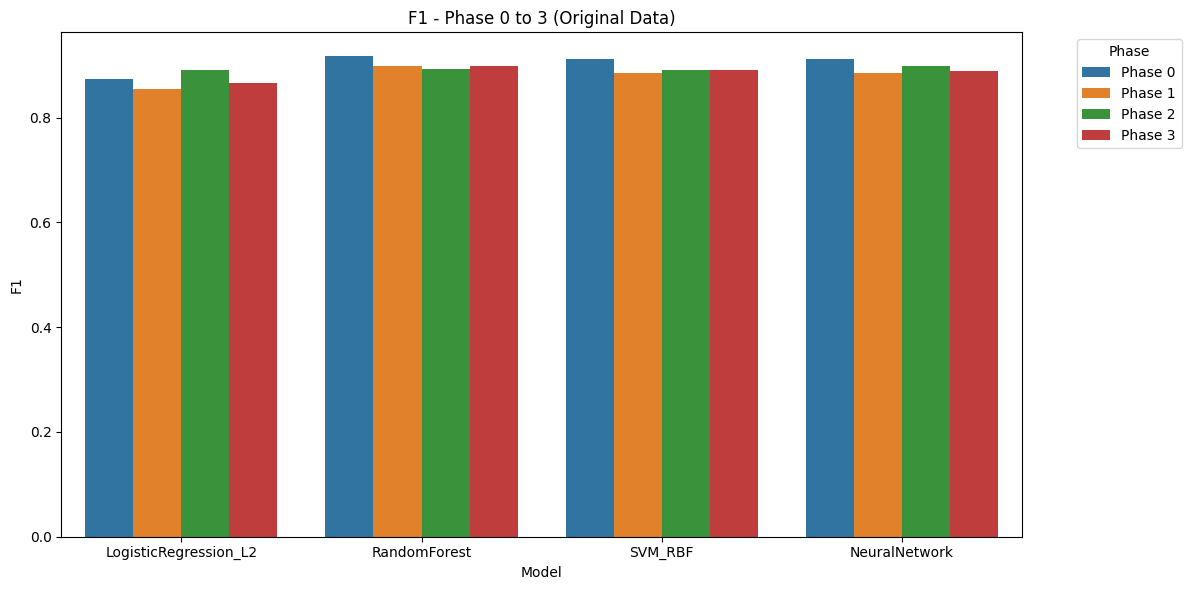

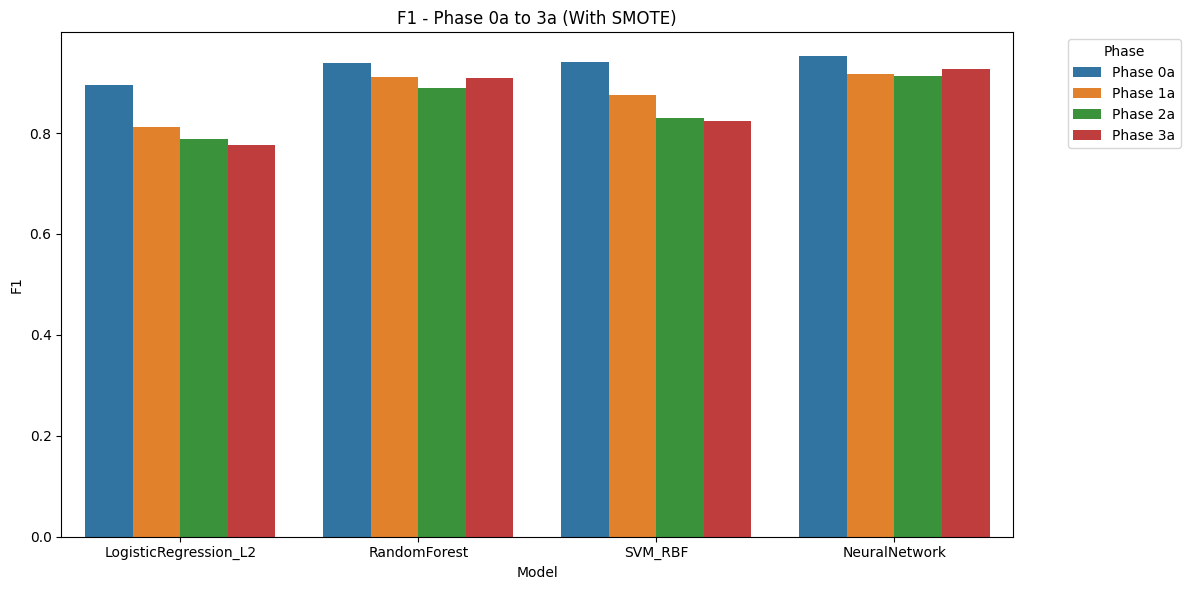

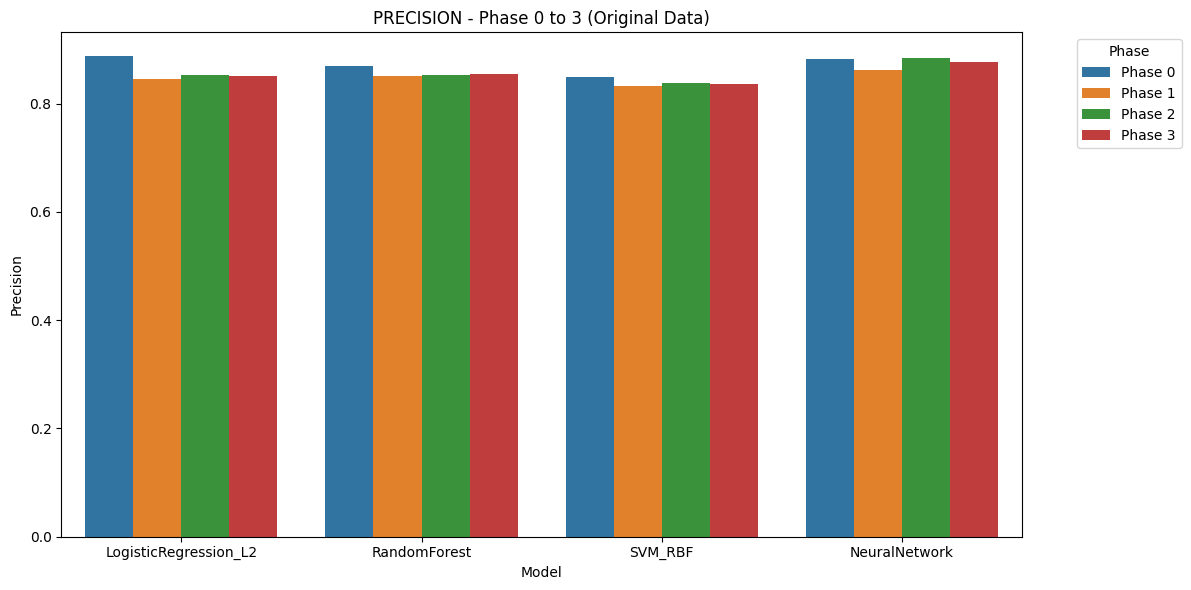

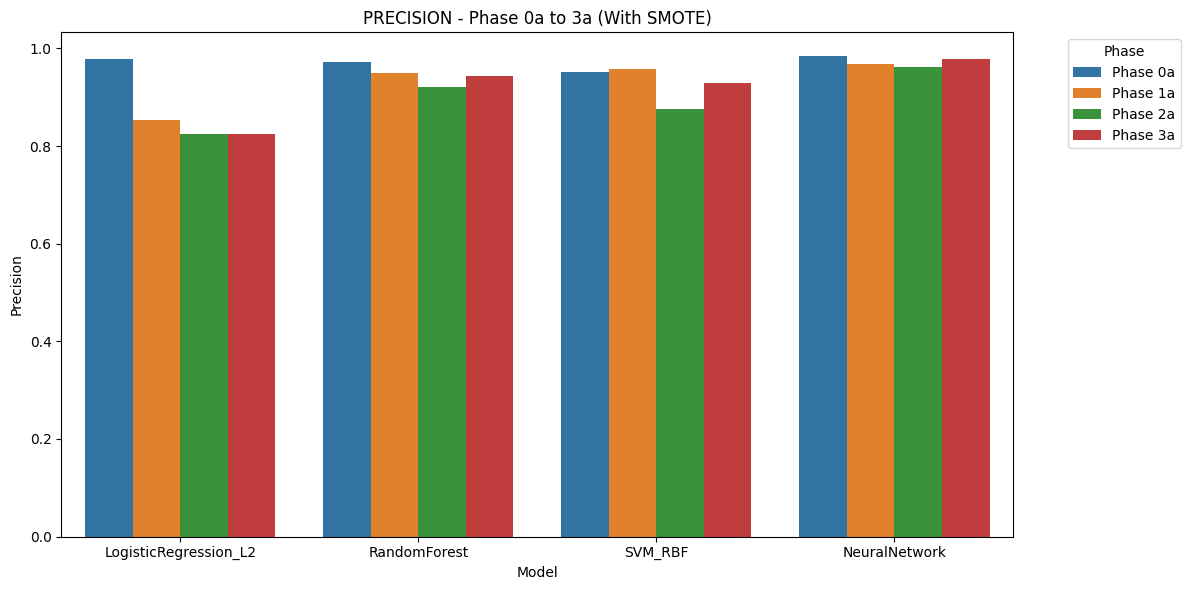

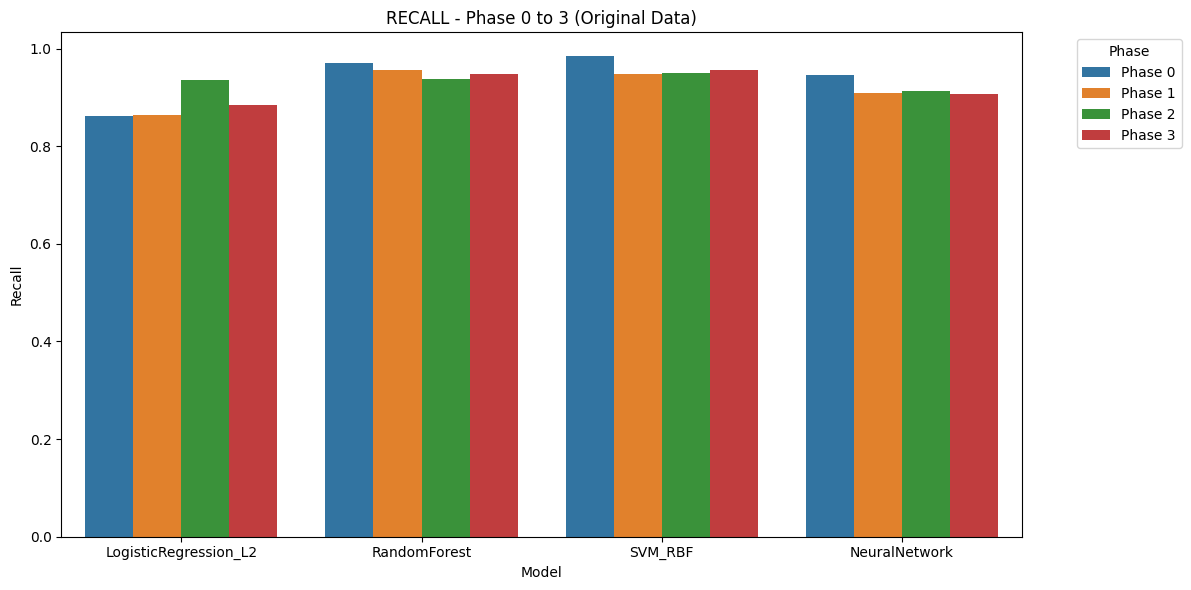

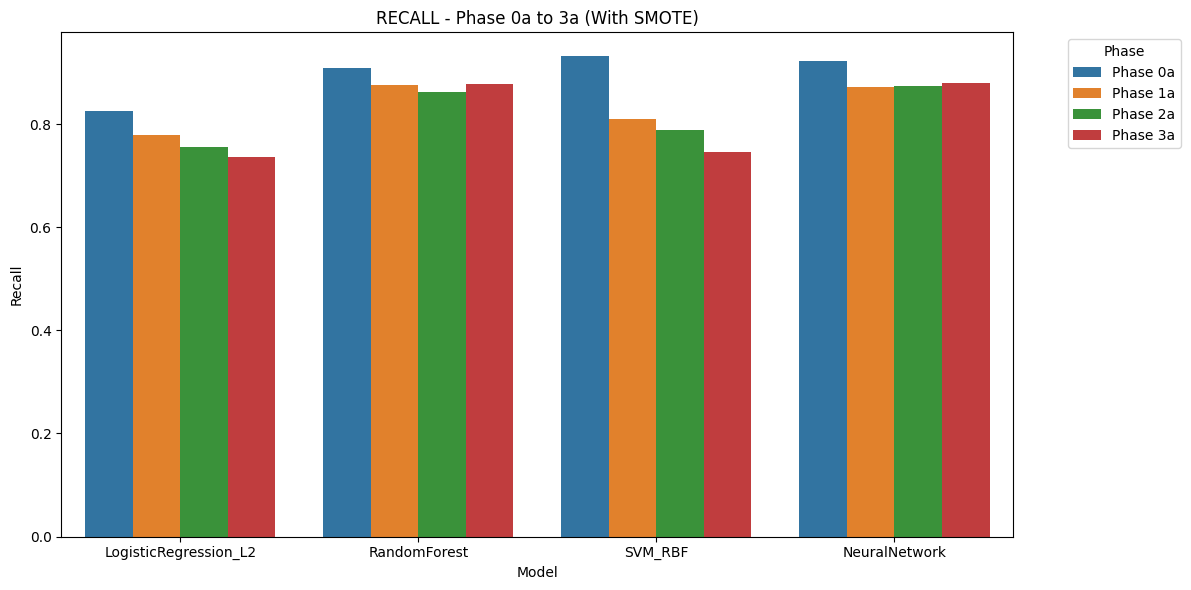

In [41]:
for i, metric in enumerate(metrics):
    # Non-SMOTE
    base_data = []
    for phase in phases_base:
        for model in models:
            value = all_results[phase][model][i]
            base_data.append({"Phase": phase, "Model": model, metric: value})
    df_base = pd.DataFrame(base_data)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_base, x="Model", y=metric, hue="Phase")
    plt.title(f"{metric.upper()} - Phase 0 to 3 (Original Data)")
    plt.ylabel(metric.capitalize())
    plt.legend(title="Phase", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # SMOTE
    smote_data = []
    for phase in phases_smote:
        for model in models:
            value = all_results[phase][model][i]
            smote_data.append({"Phase": phase, "Model": model, metric: value})
    df_smote = pd.DataFrame(smote_data)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_smote, x="Model", y=metric, hue="Phase")
    plt.title(f"{metric.upper()} - Phase 0a to 3a (With SMOTE)")
    plt.ylabel(metric.capitalize())
    plt.legend(title="Phase", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


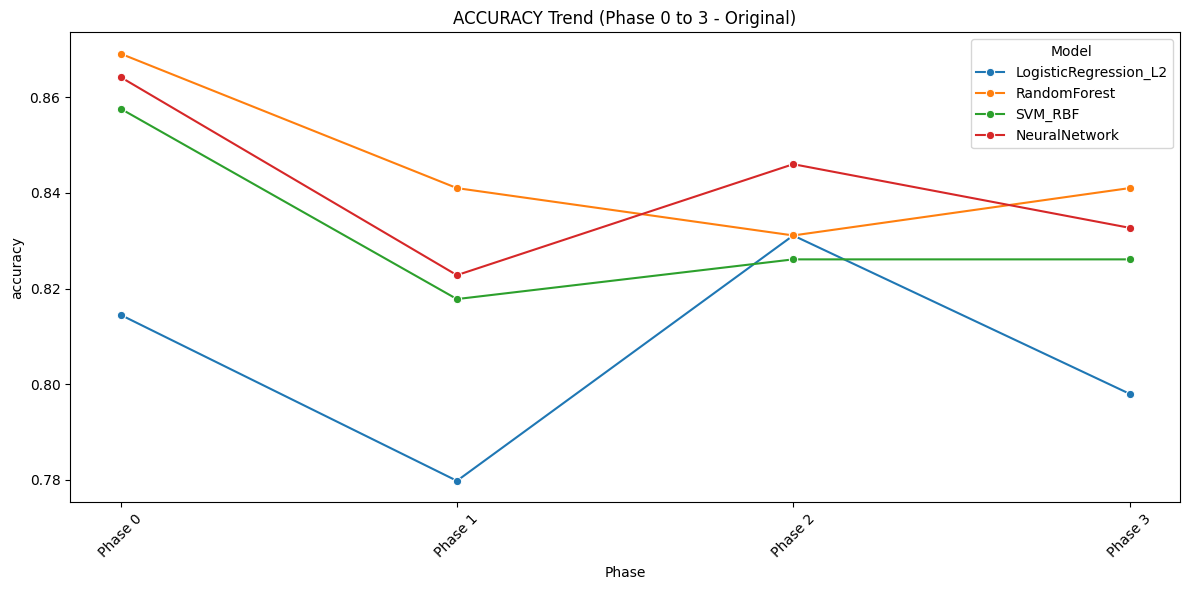

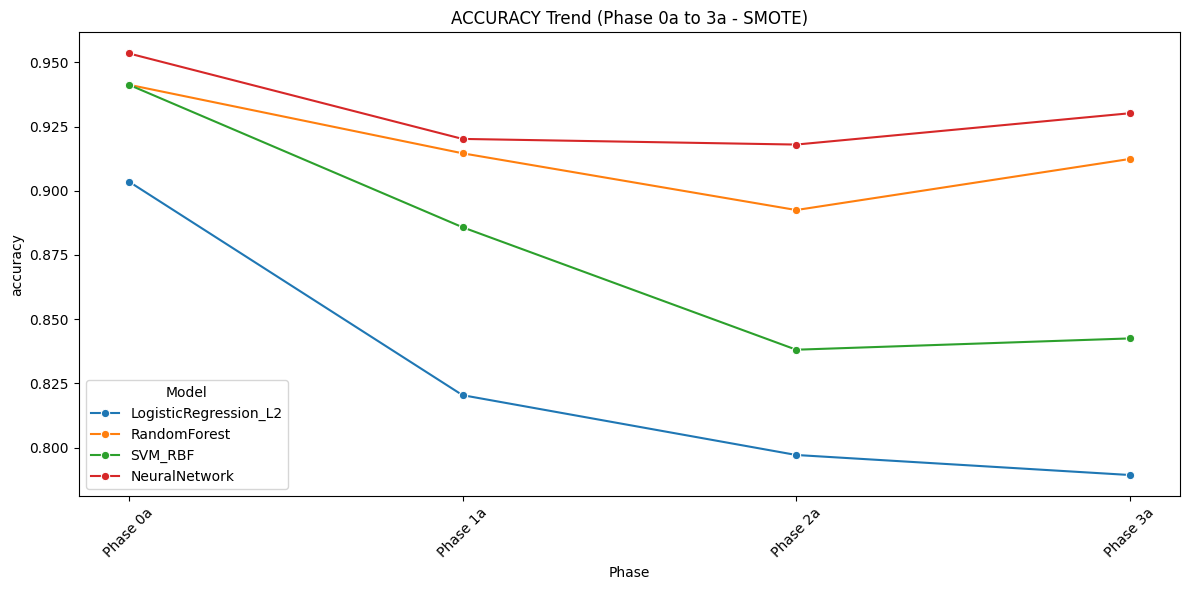

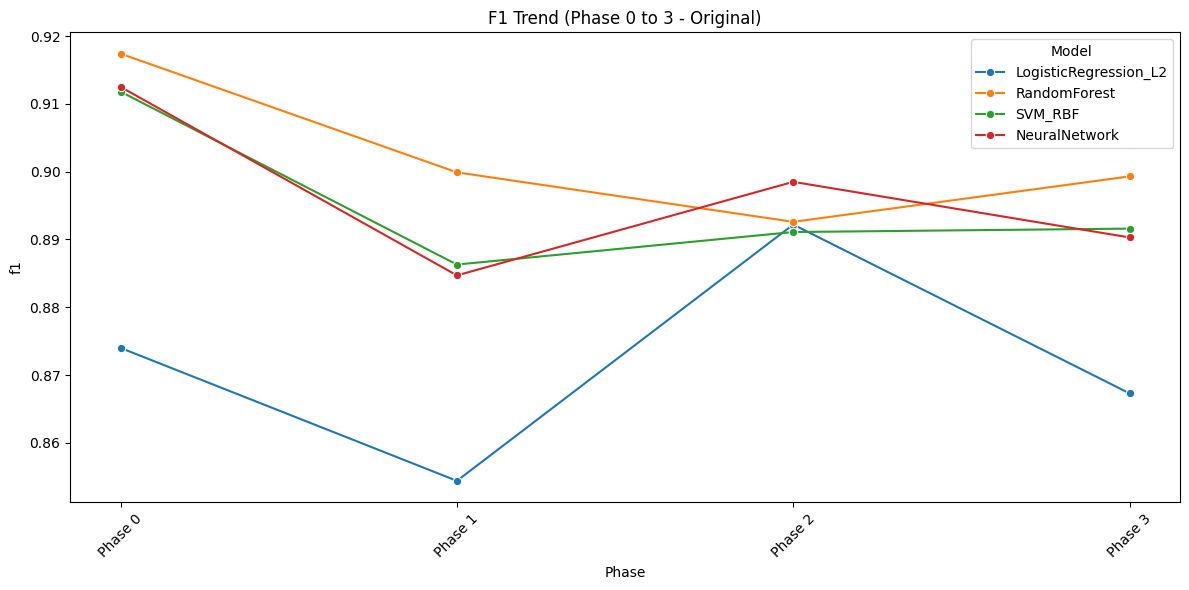

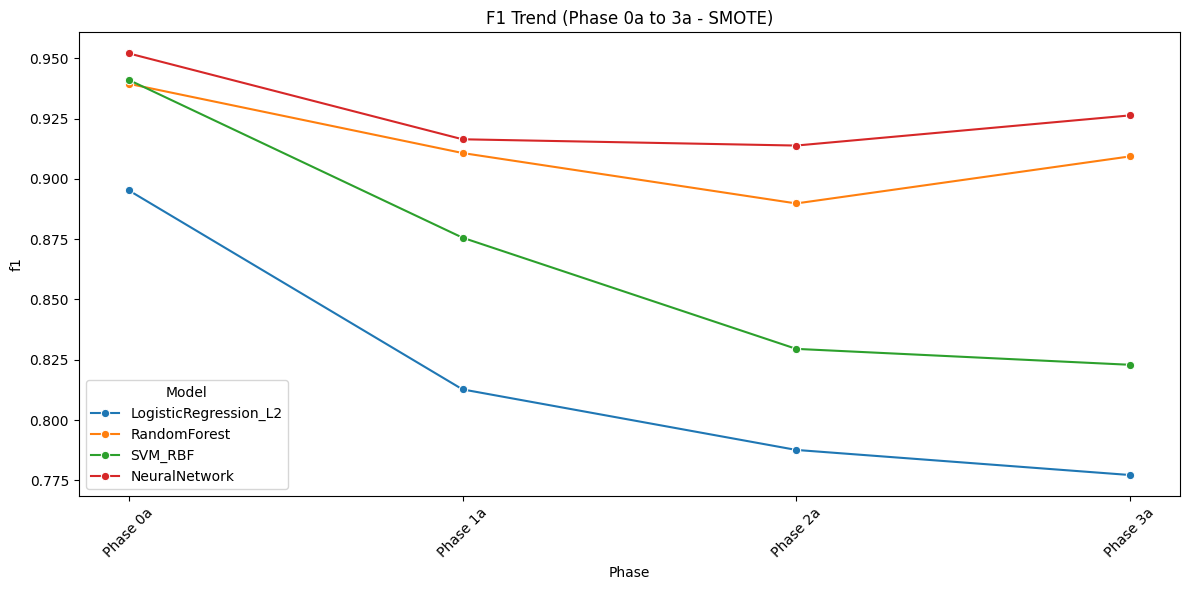

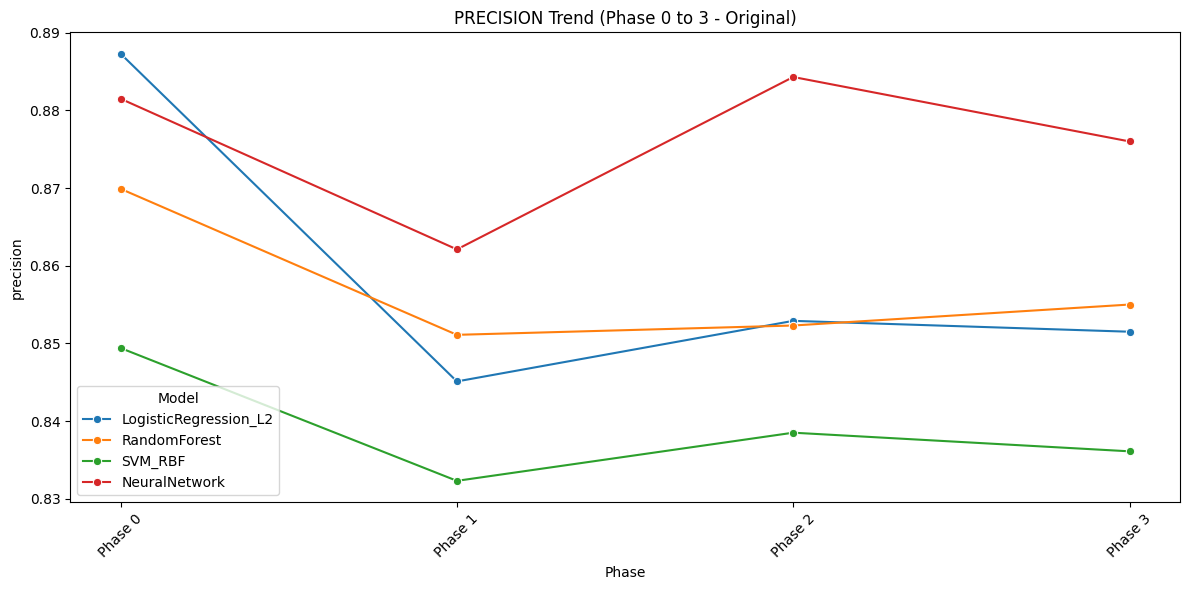

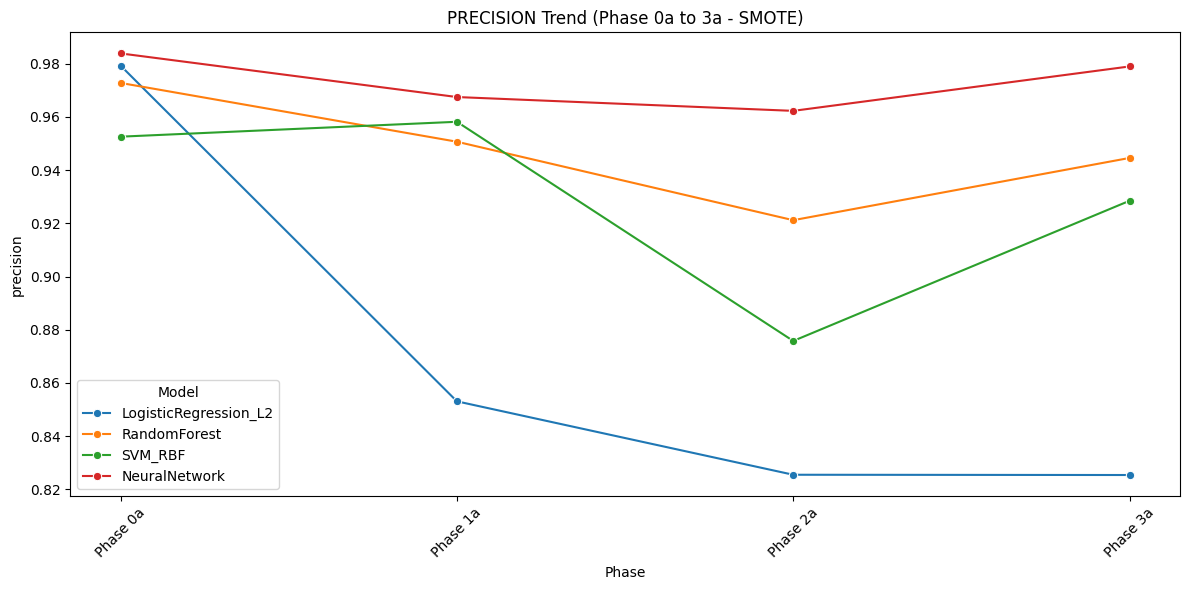

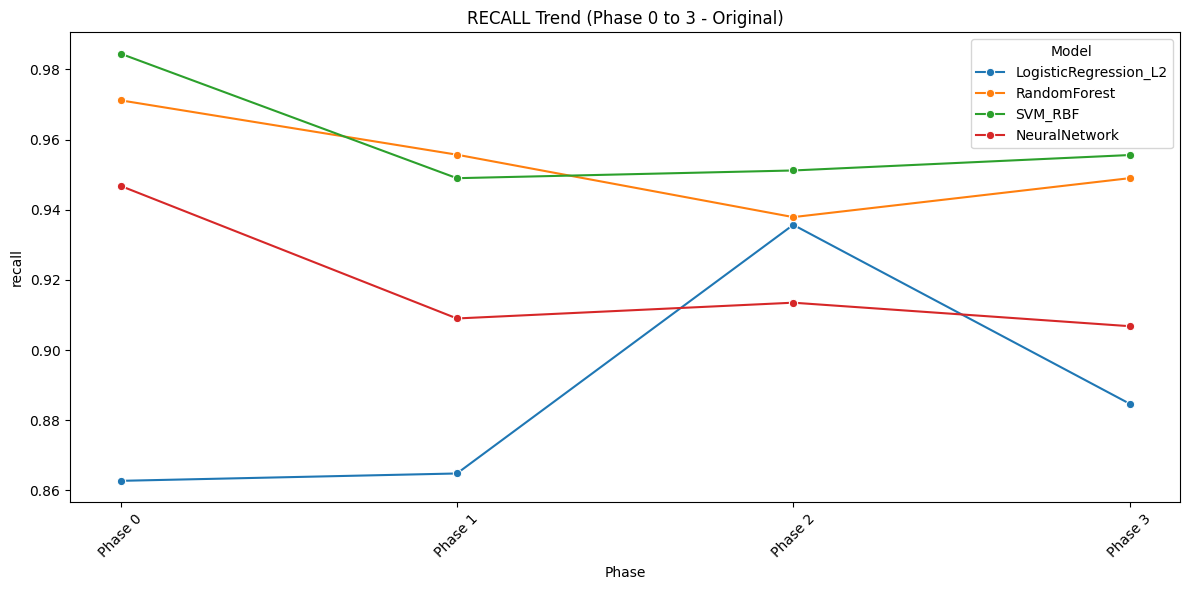

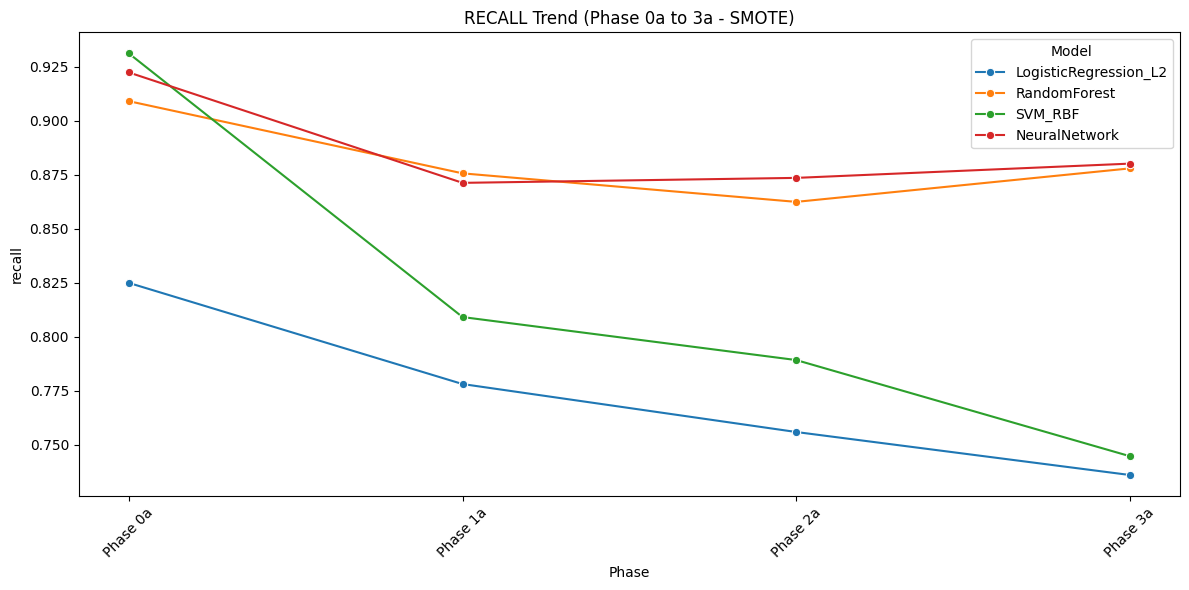

In [42]:
for i, metric in enumerate(metrics):
    # Non-SMOTE
    trend_base = []
    for model in models:
        for phase in phases_base:
            trend_base.append({
                "Phase": phase,
                "Model": model,
                metric: all_results[phase][model][i]
            })
    df_trend_base = pd.DataFrame(trend_base)

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_trend_base, x="Phase", y=metric, hue="Model", marker="o")
    plt.title(f"{metric.upper()} Trend (Phase 0 to 3 - Original)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # SMOTE
    trend_smote = []
    for model in models:
        for phase in phases_smote:
            trend_smote.append({
                "Phase": phase,
                "Model": model,
                metric: all_results[phase][model][i]
            })
    df_trend_smote = pd.DataFrame(trend_smote)

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_trend_smote, x="Phase", y=metric, hue="Model", marker="o")
    plt.title(f"{metric.upper()} Trend (Phase 0a to 3a - SMOTE)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
